<a href="https://colab.research.google.com/github/reedvenerable/Lumber-Trading-Bot/blob/main/Commodities_Trading_Bot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lumber Futures Trading Bot



In [ ]:
!pip install pandas_datareader pytrends yfinance tensorflow scikit-learn
!pip install pandas_datareader
!pip install -q pandas_datareader pytrends scikit-learn xgboost yfinance
!pip install pandas_datareader pytrends xgboost scikit-learn tensorflow
!pip install pandas_datareader pytrends
!pip install pandas_datareader pytrends scikit-learn matplotlib --quiet
!pip install nasdaq-data-link --quiet
!pip install fredapi







# Housing Signal Start Arbitrage

Quantitative trading strategy that exploits lagged correlations between U.S. housing market indicators and lumber futures prices. Uses predictive modeling to detect early trend shifts, generating long/short positions before market-wide repricing.

/usr/local/lib/python3.11/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.0380 - val_loss: 0.3915
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - loss: 0.0297 - val_loss: 0.6479
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - loss: 0.0469 - val_loss: 0.4955
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - loss: 0.0513 - val_loss: 0.5545
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0611 - val_loss: 0.4078
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0646 - val_loss: 0.3346
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 0.0629 - val_loss: 0.2750
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0640 - val_loss: 0.1712
Epoch 9/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0825 - val_loss: 0.0927
Epoch 10/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0569 - val_loss: 0.1550
Epoch 11/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0193 - val_loss: 0.2542
Epoch 12/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0

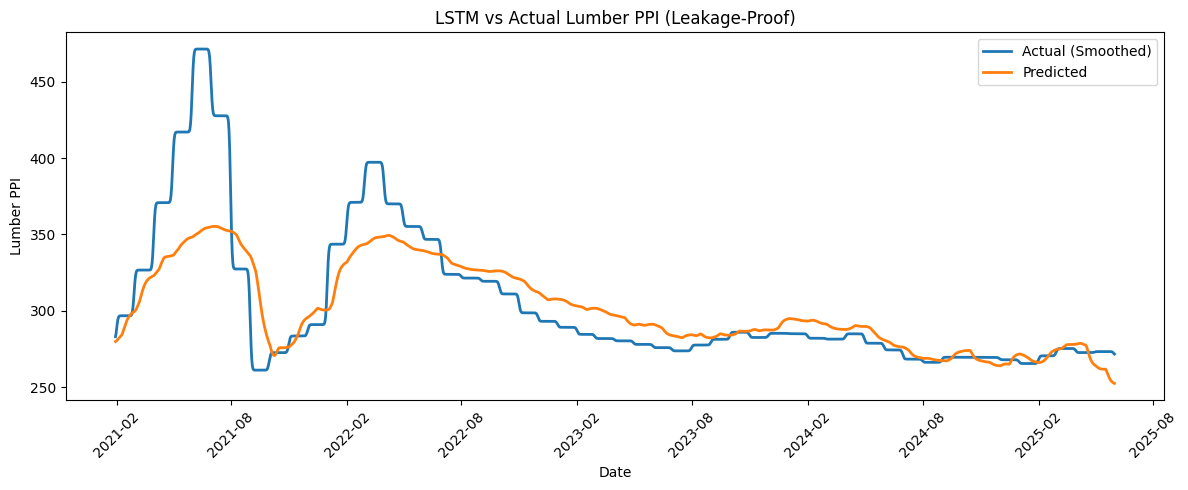

In [ ]:
# =======================
# Leakage-Proof Housing LSTM (train-only scaling, causal features)
# =======================
!pip install pandas_datareader pytrends scikit-learn --quiet

import pandas as pd, numpy as np
from pandas_datareader import data as pdr
from pytrends.request import TrendReq
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping
import matplotlib.dates as mdates
from scipy.ndimage import gaussian_filter1d
import tensorflow as tf

# --- reproducibility (optional) ---
np.random.seed(42); tf.random.set_seed(42)

# --- config ---
start_date = '2015-01-01'
end_date   = pd.Timestamp.today().strftime('%Y-%m-%d')
train_end  = '2020-12-31'
seq_length = 30

# Optional publication lags (set to >0 to be extra conservative)
PUBLISH_LAG_HOUSING_D   = 0    # e.g., 30
PUBLISH_LAG_GTREND_D    = 0    # you already shift trends 105d below; this is extra

# =======================
# FETCH DATA
# =======================
housing = pdr.DataReader('HOUST', 'fred', start_date)         # monthly
lumber_ppi = pdr.DataReader('WPU083', 'fred', start_date)     # monthly

housing.rename(columns={'HOUST': 'Housing_Starts'}, inplace=True)
lumber_ppi.rename(columns={'WPU083': 'Lumber_PPI'}, inplace=True)

# daily “known value” via forward-fill
housing_daily = housing.resample('D').ffill()
lumber_daily  = lumber_ppi.resample('D').ffill()

# Google Trends
pytrends = TrendReq(hl='en-US', tz=360)
kw_list = ['home builder near me']
pytrends.build_payload(kw_list, timeframe=f"{start_date} {end_date}")
gtrend = pytrends.interest_over_time()
if 'isPartial' in gtrend.columns:
    gtrend = gtrend.drop(columns=['isPartial'])
gtrend_daily   = gtrend.resample('D').ffill()
gtrend_shifted = gtrend_daily.shift(105)  # your original shift

# optional extra lags to simulate publication delay
housing_daily = housing_daily.shift(PUBLISH_LAG_HOUSING_D)
gtrend_shifted = gtrend_shifted.shift(PUBLISH_LAG_GTREND_D)

# =======================
# BUILD COMBINED DATAFRAME
# =======================
df = pd.concat([housing_daily, gtrend_shifted, lumber_daily], axis=1).dropna().copy()

# =======================
# CAUSAL FEATURES (no look-ahead)
#  - Lags & SMAs computed on history only
#  - Then shift all predictors by 1 day so we predict t using info up to t-1
# =======================
df['Lumber_PPI_Lag7']  = df['Lumber_PPI'].shift(7)
df['Lumber_PPI_Lag30'] = df['Lumber_PPI'].shift(30)
df['SMA_14'] = df['Lumber_PPI'].rolling(window=14, min_periods=14).mean()
df['SMA_30'] = df['Lumber_PPI'].rolling(window=30, min_periods=30).mean()

# predictors include Housing_Starts & Trends (already daily & shifted)
features = ['Housing_Starts', kw_list[0], 'Lumber_PPI_Lag7', 'Lumber_PPI_Lag30', 'SMA_14', 'SMA_30']
target   = 'Lumber_PPI'

# shift ALL predictors by 1 day so we never use same-day info to predict next value
df[features] = df[features].shift(1)

# final clean
df = df.dropna().copy()

# =======================
# SPLIT (by calendar)
# =======================
train_df = df.loc[:train_end].copy()
test_df  = df.loc[train_end:].copy()

# =======================
# TRAIN-ONLY SCALING (no leakage)
# Separate scalers for X and y
# =======================
X_train_raw = train_df[features].values
y_train_raw = train_df[[target]].values  # 2D for scaler

X_test_raw  = test_df[features].values
y_test_raw  = test_df[[target]].values

x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

X_train = x_scaler.fit_transform(X_train_raw)
y_train = y_scaler.fit_transform(y_train_raw)

# IMPORTANT: transform test using train-fitted scalers ONLY
X_test  = x_scaler.transform(X_test_raw)
y_test  = y_scaler.transform(y_test_raw)

# =======================
# SEQUENCE BUILDER (causal)
# Predict y at t using X from [t-seq_len, ..., t-1]
# =======================
def create_sequences(X, y, seq_len):
    Xs, ys = [], []
    for i in range(len(X) - seq_len):
        Xs.append(X[i:i+seq_len, :])     # seq_len rows of features
        ys.append(y[i+seq_len, 0])       # predict the next y (index i+seq_len)
    return np.array(Xs), np.array(ys)

X_tr_seq, y_tr_seq   = create_sequences(X_train, y_train, seq_length)
X_test_seq, y_test_seq = create_sequences(X_test,  y_test,  seq_length)

# Align dates for evaluation/plotting
train_idx = train_df.index
test_idx  = test_df.index
aligned_index = test_idx[seq_length:]  # dates corresponding to X_test_seq -> y_test_seq

# =======================
# LSTM MODEL (time-ordered validation; shuffle=False)
# =======================
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_tr_seq.shape[1], X_tr_seq.shape[2])),
    LSTM(32),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_absolute_error')

early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
hist = model.fit(
    X_tr_seq, y_tr_seq,
    epochs=50, batch_size=32,
    validation_split=0.1,  # with shuffle=False -> last 10% of training chronologically
    shuffle=False,
    callbacks=[early_stop],
    verbose=1
)

# =======================
# PREDICTIONS & INVERSE SCALE (target-only)
# =======================
pred_scaled = model.predict(X_test_seq)

# inverse scale using y_scaler (fit on TRAIN TARGET ONLY)
pred_actual = y_scaler.inverse_transform(pred_scaled.reshape(-1,1)).ravel()
y_test_actual = y_scaler.inverse_transform(y_test_seq.reshape(-1,1)).ravel()

# to Series
y_test_series = pd.Series(y_test_actual, index=aligned_index, name='actual')
pred_series   = pd.Series(pred_actual, index=aligned_index, name='pred')

# =======================
# EVALUATION
# =======================
mae = mean_absolute_error(y_test_series, pred_series)
print(f"[Leakage-proof] LSTM Mean Absolute Error: {mae:.2f}")

# =======================
# PLOT
# =======================
smoothed_actual = gaussian_filter1d(y_test_series.values, sigma=2)

plt.figure(figsize=(12,5))
plt.plot(y_test_series.index, smoothed_actual, label='Actual (Smoothed)', linewidth=2)
plt.plot(pred_series.index, pred_series, label='Predicted', linewidth=2)
plt.title('LSTM vs Actual Lumber PPI (Leakage-Proof)')
plt.legend()
plt.xlabel('Date'); plt.ylabel('Lumber PPI')

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.tight_layout(); plt.show()


/tmp/ipython-input-3372099566.py:165: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('conf_bin')['pnl']
/tmp/ipython-input-3372099566.py:188: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ax.plot(tr.index, bh_pct.reindex(tr.index).fillna(method='ffill'), label='Buy & Hold', linewidth=1)


Adaptive threshold (median): 0.45
Target annual vol: 15%
Cost (round-trip): 4.0 bps
Total trades (entries): 11
Hit rate: 2.28%
Turnover (avg abs Δposition): nan
Cumulative return: 25.98%
Sharpe (net, daily->annual): 0.34
Max drawdown: -11.74%

Trades by confidence bin (net pnl):
            num_trades  avg_profit
conf_bin                          
(0.4, 0.5]           3   -0.000073
(0.5, 0.6]           3   -0.000196
(0.6, 0.7]           4   -0.000238
(0.7, 0.8]           7   -0.000088
(0.8, 0.9]          16    0.020462
(0.9, 1.0]         144    0.000347


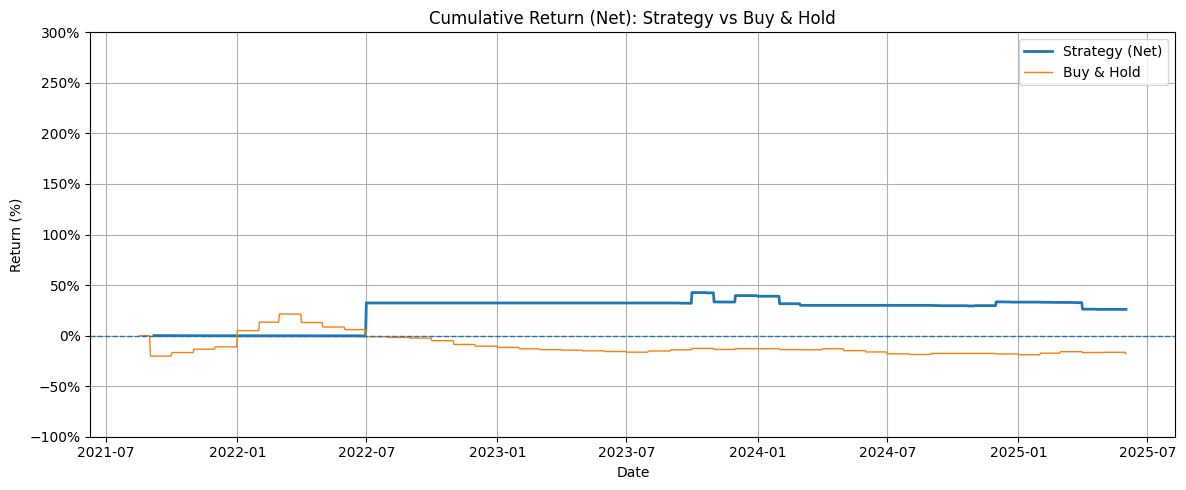

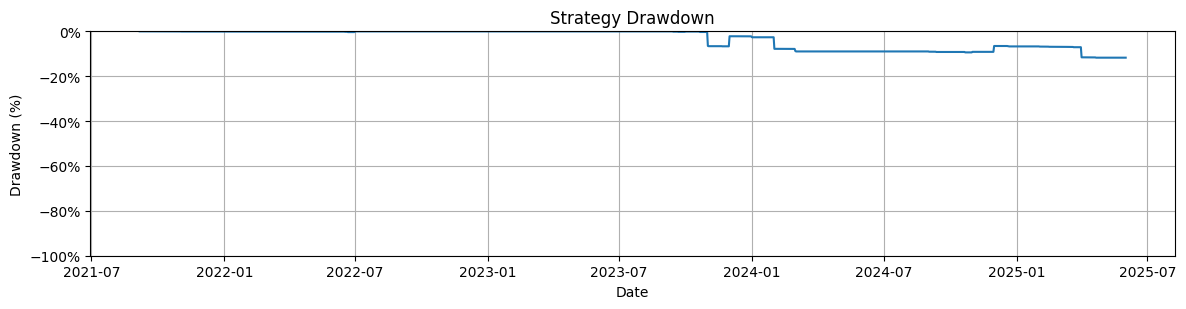

In [70]:
# === PATH A UPGRADED: Trade on earlier predictions with filters, costs, sizing, plots ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# --------- Inputs from earlier cell ----------
assert len(y_test_series) == len(pred_series)
tr = pd.DataFrame({'price_actual': y_test_series, 'pred': pred_series}).dropna().copy()

# --------- Prep & basic features ----------
tr['price_prev'] = tr['price_actual'].shift(1)
tr['actual_ret'] = tr['price_actual'].pct_change()
tr['pred_ret']   = (tr['pred'] - tr['price_prev']) / tr['price_prev']
tr['vol20']      = tr['actual_ret'].rolling(20).std()
tr['sma50']      = tr['price_actual'].rolling(50).mean()
tr['sma200']     = tr['price_actual'].rolling(200).mean()
tr = tr.dropna().copy()

# --------- Confidence (vol-aware) ----------
eps = 1e-12
strength = (tr['pred_ret'].abs() / (tr['vol20'] + eps)).clip(lower=0)
tr['confidence'] = 1 - np.exp(-strength)   # 0..1

# --------- Trend filter ----------
# Only take longs if SMA50 > SMA200; only take shorts if SMA50 < SMA200
tr['trend_long_ok']  = (tr['sma50'] > tr['sma200'])
tr['trend_short_ok'] = (tr['sma50'] < tr['sma200'])

# --------- Adaptive threshold (rolling calibration on confidence) ----------
cal_days = 180
step_days = 30
candidates = np.linspace(0.4, 0.9, 11)

thr_series = pd.Series(index=tr.index, dtype=float)

def pick_threshold(df_window):
    base = df_window.copy()
    base['pred_up'] = (base['pred_ret'] >= 0).astype(int)
    base['true_up'] = (base['actual_ret'] > 0).astype(int)
    best_thr, best_score = 0.6, -1
    for thr in candidates:
        sel = base['confidence'] >= thr
        n = int(sel.sum())
        if n < 25:
            continue
        prec = (base.loc[sel, 'pred_up'] == base.loc[sel, 'true_up']).mean()
        score = float(prec) * np.log(n + 1.0)  # precision with enough signals
        if score > best_score:
            best_thr, best_score = thr, score
    return best_thr

idx = tr.index
start = idx[0] + pd.Timedelta(days=cal_days)
cursor = start
last_thr = 0.6
while cursor <= idx[-1]:
    win = tr.loc[cursor - pd.Timedelta(days=cal_days):cursor]
    thr = pick_threshold(win)
    if np.isnan(thr):
        thr = last_thr
    thr_series.loc[cursor: cursor + pd.Timedelta(days=step_days)] = thr
    last_thr = thr
    cursor += pd.Timedelta(days=step_days)

thr_series = thr_series.ffill().reindex(tr.index).fillna(last_thr)
tr['conf_thresh'] = thr_series

# --------- Base signal from prediction ---------
raw_signal = np.sign(tr['pred_ret']).replace(0, 1)  # tie -> long

# Apply trend filter: block disallowed directions
allowed_long  = raw_signal.eq(1)  & tr['trend_long_ok']
allowed_short = raw_signal.eq(-1) & tr['trend_short_ok']
filtered_signal = np.where(allowed_long | allowed_short, raw_signal, 0)

# --------- Take rule + position sizing ----------
take = (tr['confidence'] >= tr['conf_thresh']) & (filtered_signal != 0)

# Position sizing ∝ confidence, capped [0.25, 1.0] when taking; 0 otherwise
size = np.where(take, tr['confidence'].clip(0.25, 1.0), 0.0)
position = size * filtered_signal  # signed position in [-1,1]

# --------- Volatility targeting ----------
# Scale position to hit target annualized vol (e.g., 15%). Estimate using rolling 20d realized vol.
target_annual_vol = 0.15
daily_to_annual   = np.sqrt(252)

rolling_vol = tr['actual_ret'].rolling(20).std()
scale_vol = (target_annual_vol / (rolling_vol * daily_to_annual + 1e-12)).clip(0.0, 5.0)  # cap leverage
vol_targeted_position = position * scale_vol.values

# --------- Costs & slippage on position changes ----------
# Model per-change cost in bps (enter/exit). Example: 2 bps each way = 4 bps round-trip.
cost_bps = 4.0
cost_rate = cost_bps / 10000.0

pos_prev = np.r_[0.0, vol_targeted_position[:-1]]
turnover = np.abs(vol_targeted_position - pos_prev)  # how much position changed today
cost_flow = turnover * cost_rate

# --------- Cooling off after losing streak ----------
# If last N trades lost money, pause for M days (position=0)
N_losses = 3
cooldown_days = 3

# Identify trades as days where a position is (re)entered (from 0 to nonzero)
entered = (np.abs(pos_prev) < 1e-12) & (np.abs(vol_targeted_position) > 1e-12)
# Daily PnL before cooldown decisions (gross)
gross_pnl = pos_prev * tr['actual_ret'].values
# Build a cooldown mask
cooldown_mask = np.zeros(len(tr), dtype=bool)
loss_streak = 0
cooldown_counter = 0
for i in range(len(tr)):
    if cooldown_counter > 0:
        cooldown_mask[i] = True
        cooldown_counter -= 1
        continue
    if entered[i]:
        # Evaluate last trade outcome if a complete trade occurred (approx: sign change or to zero)
        # Simpler heuristic: if yesterday's gross_pnl < 0, count as a loss
        if i > 0 and gross_pnl[i-1] < 0:
            loss_streak += 1
        else:
            loss_streak = 0
        if loss_streak >= N_losses:
            cooldown_counter = cooldown_days
            loss_streak = 0

# Zero out position on cooldown days
vol_targeted_position = np.where(cooldown_mask, 0.0, vol_targeted_position)

# Recompute pos_prev/turnover/cost after cooldown
pos_prev = np.r_[0.0, vol_targeted_position[:-1]]
turnover = np.abs(vol_targeted_position - pos_prev)
cost_flow = turnover * cost_rate

# --------- Net PnL ----------
pnl = pos_prev * tr['actual_ret'].values - cost_flow

tr['position']  = vol_targeted_position
tr['pnl']       = pnl
tr['trade']     = np.abs(vol_targeted_position) > 0
tr['cum_return']     = (tr['pnl'] + 1.0).cumprod()
tr['cum_return_pct'] = tr['cum_return'] - 1.0

# --------- Metrics ----------
total_trades = int(((np.abs(pos_prev) < 1e-12) & (np.abs(vol_targeted_position) > 1e-12)).sum())
hit_rate = (pnl[pnl != 0] > 0).mean() if (pnl != 0).any() else 0.0
avg_turnover = turnover.mean()
cum_return = tr['cum_return'].iloc[-1] - 1.0 if len(tr) else 0.0
sharpe = (tr['pnl'].mean() / (tr['pnl'].std() + 1e-12) * np.sqrt(252)) if tr['pnl'].std() > 0 else 0.0

# Max drawdown
curve = tr['cum_return']
roll_max = curve.cummax()
drawdown = (curve - roll_max) / roll_max
max_dd = drawdown.min()

# Confidence bins (executed days only)
bins = np.arange(0.4, 1.01, 0.1)
tr['conf_bin'] = pd.cut(tr['confidence'], bins, right=True, include_lowest=False)
summary = (tr.loc[tr['trade']]
           .groupby('conf_bin')['pnl']
           .agg(['count','mean'])
           .rename(columns={'count':'num_trades','mean':'avg_profit'}))

print(f"Adaptive threshold (median): {tr['conf_thresh'].median():.2f}")
print(f"Target annual vol: {target_annual_vol:.0%}")
print(f"Cost (round-trip): {cost_bps:.1f} bps")
print(f"Total trades (entries): {total_trades}")
print(f"Hit rate: {hit_rate:.2%}")
print(f"Turnover (avg abs Δposition): {avg_turnover:.4f}")
print(f"Cumulative return: {cum_return:.2%}")
print(f"Sharpe (net, daily->annual): {sharpe:.2f}")
print(f"Max drawdown: {max_dd:.2%}\n")
print("Trades by confidence bin (net pnl):")
print(summary.fillna(0))

# --------- Plots: equity & drawdown, with buy&hold overlay ----------
# Buy & hold on the same dates (normalized to start at 0%)
bh = (1.0 + tr['actual_ret'].fillna(0)).cumprod()
bh_pct = bh - 1.0

fig, ax = plt.subplots(figsize=(12,5))
ax.plot(tr.index, tr['cum_return_pct'], label='Strategy (Net)', linewidth=2)
ax.plot(tr.index, bh_pct.reindex(tr.index).fillna(method='ffill'), label='Buy & Hold', linewidth=1)
ax.axhline(0.0, linestyle='--', linewidth=1)
ax.set_title('Cumulative Return (Net): Strategy vs Buy & Hold')
ax.set_xlabel('Date'); ax.set_ylabel('Return (%)')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
ax.set_ylim(-1.0, 3.0)  # -100% to +300%
ax.grid(True); ax.legend(); plt.tight_layout()
plt.show()

# Drawdown plot
fig, ax = plt.subplots(figsize=(12,3.2))
ax.plot(tr.index, drawdown, linewidth=1.5)
ax.set_title('Strategy Drawdown')
ax.set_xlabel('Date'); ax.set_ylabel('Drawdown (%)')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
ax.set_ylim(-1.0, 0.0)
ax.grid(True); plt.tight_layout()
plt.show()



# Futures Curve Arbitrage Model

* Premise: Use long short-term memory neural networks to learn historical seasonality of lumber prices and predict turning points.
* Edge: Capture non-linear seasonal shifts (e.g., pre-spring ramp-up or hurricane rebuilding demand).




/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.1

[diag] AUC=0.857 | Brier=0.0942 | [FRED] WPU083 + synthetic F2–F4 (proxy)


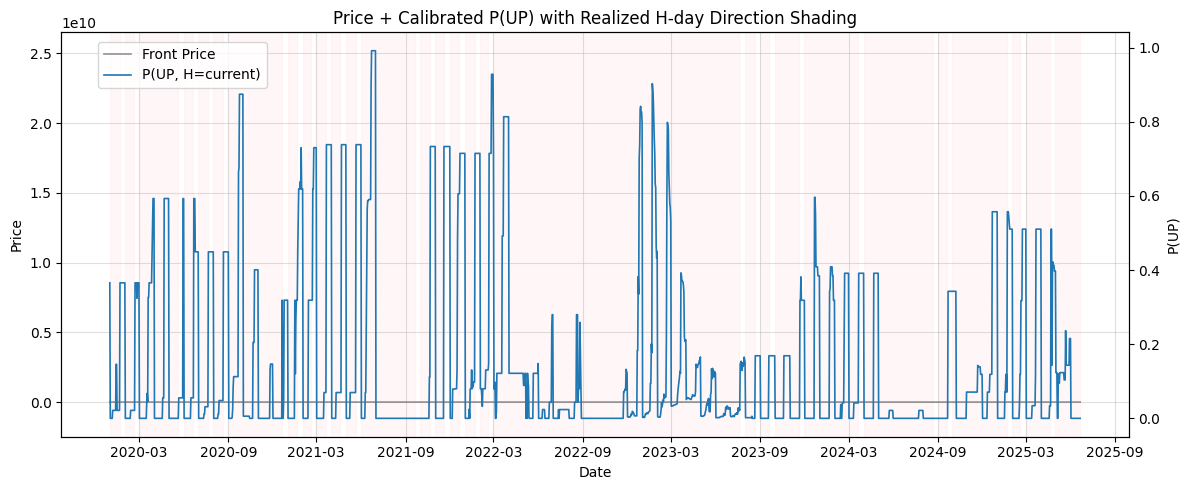

No feature importance collected (too few segments or models not fitted).


In [ ]:
# === Futures Curve Classifier — robust, self-contained ===
# This cell overwrites any previous helpers to avoid stale definitions.

import numpy as np, pandas as pd
import matplotlib.pyplot as plt, matplotlib.dates as mdates

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss, roc_auc_score, brier_score_loss

# ---------------- CONFIG ----------------
RANDOM_STATE   = 42
WF_STEP_DAYS   = 63
BAND_SIGMA     = 0.25
DIR_THR_BASE   = 0.0005
TEST_START     = pd.Timestamp('2020-01-01')  # safe default

# ---------------- HARDENED HELPERS (always redefine) ----------------
try:
    import yfinance as yf
    import logging as _logging
    _logging.getLogger("yfinance").setLevel(_logging.ERROR)
except Exception:
    yf = None
try:
    from pandas_datareader import data as pdr
except Exception:
    pdr = None

START_TS = pd.Timestamp('2015-01-01')
TODAY_TS = pd.Timestamp.today().normalize()

def _ensure_dt_index(obj):
    out = obj.copy()
    if not isinstance(out.index, pd.DatetimeIndex):
        out.index = pd.to_datetime(out.index)
    return out

def _clamp_range(df, start_ts=START_TS, end_ts=TODAY_TS):
    df = _ensure_dt_index(df)
    mask = pd.Series(True, index=df.index)
    mask &= (df.index >= start_ts)
    mask &= (df.index <= end_ts)
    return df.loc[mask]

def _synthesize_deferreds_from_front(f1: pd.Series) -> pd.DataFrame:
    f1 = _ensure_dt_index(f1.dropna().rename('F1'))
    df = pd.DataFrame({'F1': f1})
    df['F2'] = df['F1'].ewm(span=10, adjust=False).mean().shift(5)
    df['F3'] = df['F1'].ewm(span=20, adjust=False).mean().shift(10)
    df['F4'] = df['F1'].ewm(span=40, adjust=False).mean().shift(20)
    return _clamp_range(df.dropna())

def _try_yf_symbols(symbols):
    if yf is None:
        return None, None
    for sym in symbols:
        try:
            df = yf.download(
                sym,
                start=START_TS,
                end=TODAY_TS + pd.Timedelta(days=1),
                auto_adjust=False,
                progress=False,
            )
            if isinstance(df, pd.DataFrame) and not df.empty:
                close_col = 'Adj Close' if 'Adj Close' in df.columns else ('Close' if 'Close' in df.columns else None)
                if close_col is None:
                    continue
                f1 = df[close_col].rename('F1').dropna()
                curve = _synthesize_deferreds_from_front(f1)
                if not curve.empty:
                    return curve, f"[yfinance] {sym} + synthetic F2–F4"
        except Exception:
            continue
    return None, None

def _try_fred():
    if pdr is None:
        return None, None
    try:
        fred = pdr.DataReader('WPU083', 'fred', START_TS, TODAY_TS)['WPU083']
        f1 = fred.resample('D').ffill().rename('F1')
        curve = _synthesize_deferreds_from_front(f1)
        if not curve.empty:
            return curve, "[FRED] WPU083 + synthetic F2–F4 (proxy)"
    except Exception:
        pass
    return None, None

def _fallback_synthetic():
    idx = pd.bdate_range(START_TS, TODAY_TS, freq='B')
    rng = np.random.default_rng(7)
    ret = rng.normal(0, 0.0015, size=len(idx))
    f1 = pd.Series(300 + np.cumsum(ret), index=idx, name='F1')
    return _synthesize_deferreds_from_front(f1), "[synthetic] AR(1)-like F1 + synthetic F2–F4"

def fetch_curve_auto():
    """Front-nearby via yfinance (preferred), else FRED, else synthetic. Always returns F1–F4 DataFrame."""
    curve, note = _try_yf_symbols(['LBS=F', 'LB=F', 'LBR=F'])  # LBR=F is current Yahoo lumber future
    if curve is not None:
        return _clamp_range(curve), note
    curve, note = _try_fred()
    if curve is not None:
        return _clamp_range(curve), note
    curve, note = _fallback_synthetic()
    return _clamp_range(curve), note

def build_features(curve: pd.DataFrame) -> pd.DataFrame:
    df = _ensure_dt_index(curve.copy())
    # spreads / ratios
    df['sprd_21'] = df['F2'] - df['F1']
    df['sprd_31'] = df['F3'] - df['F1']
    df['sprd_41'] = df['F4'] - df['F1']
    df['ratio_21'] = df['F2']/df['F1'] - 1.0
    df['ratio_31'] = df['F3']/df['F1'] - 1.0
    df['ratio_41'] = df['F4']/df['F1'] - 1.0
    # Nelson–Siegel factors
    T = np.array([0.10, 0.30, 0.50, 0.70], dtype=float)
    def ns(row, lam=1.0):
        phi1 = (1 - np.exp(-lam*T)) / (lam*T)
        phi2 = phi1 - np.exp(-lam*T)
        X = np.column_stack([np.ones_like(T), phi1, phi2])
        y = np.log(np.array([row.F1, row.F2, row.F3, row.F4]) + 1e-12)
        beta = np.linalg.lstsq(X, y, rcond=None)[0]
        return pd.Series({'ns_lvl': beta[0], 'ns_slp': beta[1], 'ns_crv': beta[2]})
    nsb = df[['F1','F2','F3','F4']].apply(ns, axis=1)
    df = pd.concat([df, nsb], axis=1)
    # dynamics
    df['ret1']  = df['F1'].pct_change()
    df['ret5']  = df['F1'].pct_change(5)
    df['ret20'] = df['F1'].pct_change(20)
    df['rv20']  = df['ret1'].rolling(20).std()*np.sqrt(252)
    # seasonality
    m = df.index.month
    df['mo_sin'] = np.sin(2*np.pi*m/12); df['mo_cos'] = np.cos(2*np.pi*m/12)
    return _clamp_range(df.dropna())

# ---------------- MODEL UTILS ----------------
def _has_two_classes(y): return np.unique(y).size >= 2
def _score_probs(y_true, p):
    p = np.clip(p, 1e-6, 1-1e-6)
    if _has_two_classes(y_true): return log_loss(y_true, p)
    return np.mean((y_true - p)**2)

def _temp_scale(p, T):
    from scipy.special import logit, expit
    z = logit(np.clip(p, 1e-6, 1-1e-6))
    return expit(z / T)

def _safe_val_len(n, max_val=252, min_val=60):
    v = min(max_val, max(min_val, int(0.2*n)))
    if n - v < 150: v = max(min_val, min(50, n//5))
    return max(min_val, min(v, n-120)) if n > 240 else max(40, n//4)

# ---------------- TRAIN / PREDICT ----------------
def train_walkforward_lite(H=5):
    # 1) data + features
    curve, note = fetch_curve_auto()
    feats = build_features(curve)

    # leakage-safe lag
    exclude_cols = set(['y_logretHp','F1','F2','F3','F4'])
    FEATS = [c for c in feats.columns if c not in exclude_cols]
    feats[FEATS] = feats[FEATS].shift(1)

    # target
    feats['y_logretHp'] = np.log(feats['F1'].shift(-H) / feats['F1'])
    feats = feats.dropna(subset=['F1','F2','F3','F4','y_logretHp'])

    y_bin = (feats['y_logretHp'] > 0).astype(int)
    df_all = feats[FEATS].copy()
    df_all['y']          = y_bin
    df_all['y_realized'] = feats['y_logretHp']
    df_all['F1']         = feats['F1']

    # 2) split (no None comparisons)
    first_valid, last_valid = df_all.index.min(), df_all.index.max()
    ts_raw = TEST_START
    TEST_START_TS = pd.to_datetime(ts_raw, errors='coerce')
    bd_lookback = pd.tseries.offsets.BDay(252)

    if pd.isna(TEST_START_TS):
        auto_ts = max(first_valid + bd_lookback, first_valid + (last_valid-first_valid)/2)
    else:
        auto_ts = pd.Timestamp(TEST_START_TS)

    if auto_ts < first_valid + bd_lookback:
        auto_ts = first_valid + bd_lookback
    if auto_ts > last_valid - pd.tseries.offsets.BDay(20):
        auto_ts = first_valid + (last_valid-first_valid)/2
    auto_ts = pd.Timestamp(auto_ts).normalize()

    train_mask = (df_all.index < auto_ts)
    test_mask  = (df_all.index >= auto_ts)
    df_test = df_all.loc[test_mask]
    if df_test.empty:
        raise RuntimeError(f"No test rows after split at {auto_ts.date()}.")

    # 3) walk-forward segments
    test_dates = df_test.index
    segment_starts = [test_dates.min()]
    while segment_starts[-1] < test_dates.max():
        nxt = pd.Timestamp((segment_starts[-1] + pd.tseries.offsets.BDay(WF_STEP_DAYS)).date())
        if nxt > test_dates.max(): break
        segment_starts.append(nxt)

    prob_out, imp_rows = [], []
    for seg_start in segment_starts:
        seg_end  = seg_start + pd.tseries.offsets.BDay(WF_STEP_DAYS-1)
        seg_mask = (df_test.index >= seg_start) & (df_test.index <= seg_end)
        if seg_mask.sum()==0:
            continue

        hist_cutoff = seg_start - pd.tseries.offsets.BDay(1)
        hist = df_all.loc[df_all.index <= hist_cutoff].copy()
        if len(hist) < 400:
            continue

        X_hist = hist[FEATS].values
        y_hist = hist['y'].values
        if len(y_hist) < 240:
            continue

        vlen = _safe_val_len(len(y_hist))
        X_tr, y_tr = X_hist[:-vlen], y_hist[:-vlen]
        X_val, y_val = X_hist[-vlen:], y_hist[-vlen:]

        scaler = StandardScaler()
        X_tr_s  = scaler.fit_transform(X_tr)
        X_val_s = scaler.transform(X_val)

        # HGB small grid
        hgb_cands = []
        for depth in [4,6]:
            for lr in [0.03, 0.06]:
                h = HistGradientBoostingClassifier(max_depth=depth, learning_rate=lr, max_iter=450,
                                                   min_samples_leaf=25, random_state=RANDOM_STATE)
                h.fit(X_tr_s, y_tr)
                pv = h.predict_proba(X_val_s)[:,1]
                hgb_cands.append((_score_probs(y_val,pv), h, pv))
        hgb_cands.sort(key=lambda t:t[0])
        hgb_best, p_hgb_val = hgb_cands[0][1], hgb_cands[0][2]

        if _has_two_classes(y_val):
            hgb_cal = CalibratedClassifierCV(hgb_best, method='isotonic', cv='prefit').fit(X_val_s, y_val)
            def hgb_pred(Xs): return hgb_cal.predict_proba(Xs)[:,1]
            p_hgb_val = hgb_cal.predict_proba(X_val_s)[:,1]
        else:
            def hgb_pred(Xs): return hgb_best.predict_proba(Xs)[:,1]

        # RF small grid
        rf_cands=[]
        for n in [300, 600]:
            rf = RandomForestClassifier(n_estimators=n, min_samples_leaf=5, n_jobs=-1,
                                        class_weight='balanced_subsample', random_state=RANDOM_STATE)
            rf.fit(X_tr_s, y_tr)
            pv = rf.predict_proba(X_val_s)[:,1]
            rf_cands.append((_score_probs(y_val,pv), rf, pv))
        rf_cands.sort(key=lambda t:t[0])
        rf_best, p_rf_val = rf_cands[0][1], rf_cands[0][2]

        if _has_two_classes(y_val):
            rf_cal = CalibratedClassifierCV(rf_best, method='isotonic', cv='prefit').fit(X_val_s, y_val)
            def rf_pred(Xs): return rf_cal.predict_proba(Xs)[:,1]
            p_rf_val = rf_cal.predict_proba(X_val_s)[:,1]
        else:
            def rf_pred(Xs): return rf_best.predict_proba(Xs)[:,1]

        # blend + temperature
        ws = np.linspace(0,1,11)
        w_hgb = min((( _score_probs(y_val, w*p_hgb_val+(1-w)*p_rf_val), w) for w in ws), key=lambda t:t[0])[1]
        p_mix_val = w_hgb*p_hgb_val + (1-w_hgb)*p_rf_val
        Ts = np.linspace(0.7, 3.0, 18)
        T_star = min(((T, _score_probs(y_val, _temp_scale(p_mix_val,T))) for T in Ts), key=lambda t:t[1])[0]

        X_seg_s = scaler.transform(df_test.loc[seg_mask, FEATS].values)
        p_up = _temp_scale(w_hgb*hgb_pred(X_seg_s) + (1-w_hgb)*rf_pred(X_seg_s), T_star)
        seg_idx = df_test.loc[seg_mask].index
        prob_out.append(pd.Series(p_up, index=seg_idx))

        # blended importances (normalize to sum=1)
        ih = getattr(hgb_best, 'feature_importances_', None)
        ir = getattr(rf_best, 'feature_importances_', None)
        if ih is not None and ir is not None:
            ih = np.maximum(ih,0); ih = ih/(ih.sum()+1e-12)
            ir = np.maximum(ir,0); ir = ir/(ir.sum()+1e-12)
            iblend = 0.5*ih + 0.5*ir
            imp_rows.append(pd.Series(iblend, index=FEATS, name=seg_idx[0]))

    if not prob_out:
        raise RuntimeError("No segments produced predictions.")

    cls_prob = pd.concat(prob_out).sort_index().rename('p_up')
    realized = feats['y_logretHp'].reindex(cls_prob.index)
    price    = feats['F1'].reindex(cls_prob.index)

    # diagnostics
    try:
        auc = roc_auc_score((realized>0).astype(int), cls_prob)
    except Exception:
        auc = np.nan
    brier = brier_score_loss((realized>0).astype(int).values,
                             np.clip(cls_prob.values,1e-6,1-1e-6))

    # importance long-form
    imp_long = None
    if imp_rows:
        imp_df = pd.DataFrame(imp_rows).sort_index()
        imp_long = imp_df

    return cls_prob, realized, price, imp_long, {'AUC':auc, 'Brier':brier, 'note':note}

# ---------------- RUN ----------------
H_current = int(globals().get('H', 5))
cls_prob_H, realized_H, price_H, imp_long, diag = train_walkforward_lite(H=H_current)
print(f"[diag] AUC={diag['AUC']:.3f} | Brier={diag['Brier']:.4f} | {diag['note']}")

# ---------------- PLOTS ----------------
fig, ax1 = plt.subplots(figsize=(12,5))
ax1.plot(price_H.index, price_H.values, lw=1.2, label='Front Price', alpha=0.85, color='tab:gray')
ax2 = ax1.twinx()
ax2.plot(cls_prob_H.index, cls_prob_H.values, lw=1.2, label='P(UP, H=current)', color='tab:blue')

up_mask = (realized_H > 0).astype(int).reindex(cls_prob_H.index).fillna(0)
ax1.fill_between(cls_prob_H.index, ax1.get_ylim()[0], ax1.get_ylim()[1],
                 where=up_mask.values>0, color='green', alpha=0.06, transform=ax1.get_xaxis_transform(), step='pre')
ax1.fill_between(cls_prob_H.index, ax1.get_ylim()[0], ax1.get_ylim()[1],
                 where=up_mask.values==0, color='red',   alpha=0.03, transform=ax1.get_xaxis_transform(), step='pre')

ax1.set_title('Price + Calibrated P(UP) with Realized H-day Direction Shading')
ax1.set_xlabel('Date'); ax1.set_ylabel('Price'); ax2.set_ylabel('P(UP)')
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
fig.legend(loc='upper left', bbox_to_anchor=(0.08,0.92))
plt.xticks(rotation=45); ax1.grid(True, alpha=0.4); plt.tight_layout(); plt.show()

if imp_long is not None and not imp_long.empty:
    top_feats = imp_long.mean().sort_values(ascending=False).head(12).index
    imp_small = imp_long[top_feats]
    fig, ax = plt.subplots(figsize=(12,6))
    im = ax.imshow(imp_small.values.T, aspect='auto', interpolation='nearest')
    ax.set_yticks(range(len(top_feats))); ax.set_yticklabels(top_feats)
    ax.set_xticks(range(len(imp_small.index)))
    ax.set_xticklabels([d.strftime('%Y-%m') for d in imp_small.index], rotation=45, ha='right')
    ax.set_title('Rolling (Segment) Feature Importance — blended RF/HGB (sum=1 per segment)')
    fig.colorbar(im, ax=ax, fraction=0.025, pad=0.02, label='Importance')
    plt.tight_layout(); plt.show()
else:
    print("No feature importance collected (too few segments or models not fitted).")



,H,AUC,Brier,Trades,AnnRet,AnnVol,Sharpe
3,10,0.885468,0.091278,63,0.189222,0.192130,0.984867
2,7,0.888363,0.071312,57,0.151765,0.192051,0.790232
1,5,0.887070,0.057775,37,0.033289,0.192343,0.173069
0,3,0.887215,0.038533,23,-0.029352,0.192163,-0.152743


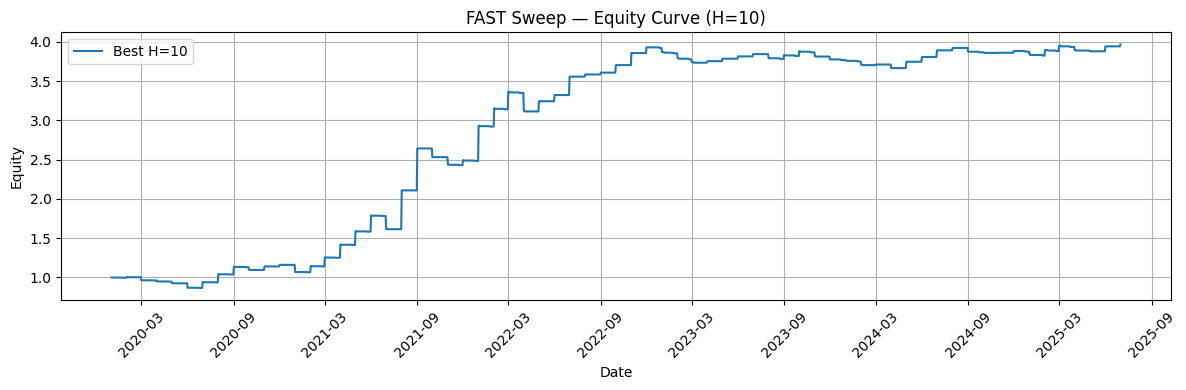

[fast sweep] Winner: H=10


In [43]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, matplotlib.dates as mdates
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score, brier_score_loss

# ----------------------- knobs (fast) -----------------------
H_list = [3, 5, 7, 10]
LONG_THR, SHORT_THR = 0.55, 0.35
COSTS_PER_TRADE = 0.001
WF_STEP_DAYS_FAST = 126
RF_TREES = 200
HGB_MAX_ITER = 200
HGB_DEPTHS = [4]
BLEND_WEIGHTS = np.linspace(0, 1, 5)
TEMP_GRID = np.linspace(0.9, 1.6, 6)
USE_ISOTONIC = False

# ----------------------- helpers -----------------------
def _has_two_classes(y):
    return np.unique(y).size >= 2

def _logloss_or_brier(y_true, p):
    p = np.clip(p, 1e-6, 1 - 1e-6)
    if _has_two_classes(y_true):
        from sklearn.metrics import log_loss
        return log_loss(y_true, p)
    return np.mean((y_true - p) ** 2)

def _temp_scale(p, T):
    from scipy.special import logit, expit
    z = logit(np.clip(p, 1e-6, 1 - 1e-6))
    return expit(z / T)

def _safe_val_len(n, max_val=200, min_val=50):
    v = min(max_val, max(min_val, int(0.15 * n)))
    if n - v < 120:
        v = max(min_val, min(40, n // 6))
    return max(min_val, min(v, n - 100)) if n > 200 else max(30, n // 5)

# ----------------------- 1) fetch once, build features once -----------------------
curve, note = fetch_curve_auto()
feats = build_features(curve).copy()

exclude_cols = set(['y_logretHp', 'F1', 'F2', 'F3', 'F4', 'sma50', 'sma200'])
FEATS = [c for c in feats.columns if c not in exclude_cols]
if FEATS:
    feats[FEATS] = feats[FEATS].ffill().bfill()
    for c in FEATS:
        feats[c] = feats[c].shift(1)

feats = feats.dropna(subset=['F1', 'F2', 'F3', 'F4']).sort_index()

# ----------------------- 2) make a single train/test split & segments -----------------------
first_valid, last_valid = feats.index.min(), feats.index.max()
auto_ts = max(pd.Timestamp(TEST_START), first_valid + pd.tseries.offsets.BDay(252))
if pd.isna(auto_ts) or auto_ts > last_valid - pd.tseries.offsets.BDay(20):
    auto_ts = pd.Timestamp(first_valid + (last_valid - first_valid) / 2).normalize()

train_mask = (feats.index < auto_ts)
test_mask = (feats.index >= auto_ts)
if feats.loc[test_mask].empty:
    raise RuntimeError("No test rows after split (fast sweep).")

scaler = StandardScaler().fit(feats.loc[train_mask, FEATS].values)

test_dates = feats.loc[test_mask].index
segment_starts = [test_dates.min()]
while segment_starts[-1] < test_dates.max():
    nxt = pd.Timestamp((segment_starts[-1] + pd.tseries.offsets.BDay(WF_STEP_DAYS_FAST)).date())
    if nxt > test_dates.max():
        break
    segment_starts.append(nxt)

# ----------------------- 3) function that trains/predicts for a given H -----------------------
def run_fast_for_H(H):
    y_logretH = np.log(feats['F1'].shift(-H) / feats['F1'])
    y_bin = (y_logretH > 0).astype(int)
    df_all = feats[FEATS].copy()
    df_all['y'] = y_bin
    df_all['retH'] = y_logretH
    df_all['F1'] = feats['F1']

    prob_out = []
    for seg_start in segment_starts:
        seg_end = seg_start + pd.tseries.offsets.BDay(WF_STEP_DAYS_FAST - 1)
        seg_mask = (df_all.index >= seg_start) & (df_all.index <= seg_end)
        if seg_mask.sum() == 0:
            continue

        hist_cutoff = seg_start - pd.tseries.offsets.BDay(1)
        hist = df_all.loc[df_all.index <= hist_cutoff].dropna(subset=['y']).copy()
        if len(hist) < 350:
            continue

        X_hist = scaler.transform(hist[FEATS].values)
        y_hist = hist['y'].values
        if len(y_hist) < 200:
            continue

        vlen = _safe_val_len(len(y_hist))
        X_tr, y_tr = X_hist[:-vlen], y_hist[:-vlen]
        X_val, y_val = X_hist[-vlen:], y_hist[-vlen:]

        # ---- fast models ----
        hgb = HistGradientBoostingClassifier(
            max_depth=HGB_DEPTHS[0], learning_rate=0.06, max_iter=HGB_MAX_ITER,
            min_samples_leaf=25, random_state=42
        ).fit(X_tr, y_tr)
        rf = RandomForestClassifier(
            n_estimators=RF_TREES, min_samples_leaf=5, n_jobs=-1,
            class_weight='balanced_subsample', random_state=42
        ).fit(X_tr, y_tr)

        p_hgb_val = hgb.predict_proba(X_val)[:, 1]
        p_rf_val = rf.predict_proba(X_val)[:, 1]

        if USE_ISOTONIC and _has_two_classes(y_val):
            hgb = CalibratedClassifierCV(hgb, method='isotonic', cv='prefit').fit(X_val, y_val)
            rf = CalibratedClassifierCV(rf, method='isotonic', cv='prefit').fit(X_val, y_val)
            p_hgb_val = hgb.predict_proba(X_val)[:, 1]
            p_rf_val = rf.predict_proba(X_val)[:, 1]

        best_w = min((( _logloss_or_brier(y_val, w*p_hgb_val + (1-w)*p_rf_val), w) for w in BLEND_WEIGHTS),
                     key=lambda t: t[0])[1]
        p_mix_val = best_w*p_hgb_val + (1-best_w)*p_rf_val
        T_star = min(((T, _logloss_or_brier(y_val, _temp_scale(p_mix_val, T))) for T in TEMP_GRID),
                     key=lambda t: t[1])[0]

        X_seg = scaler.transform(df_all.loc[seg_mask, FEATS].values)
        p_up = _temp_scale(best_w*hgb.predict_proba(X_seg)[:, 1] + (1-best_w)*rf.predict_proba(X_seg)[:, 1], T_star)
        prob_out.append(pd.Series(p_up, index=df_all.loc[seg_mask].index))

    if not prob_out:
        raise RuntimeError(f"No predictions produced for H={H}.")

    cls_prob = pd.concat(prob_out).sort_index().rename('p_up')

    # Backtest
    price = df_all['F1'].reindex(cls_prob.index)
    raw = pd.Series(0, index=cls_prob.index, dtype=int)
    raw[cls_prob > LONG_THR] = 1
    raw[cls_prob < SHORT_THR] = -1
    sig = raw.shift(1).fillna(0).astype(int)

    logret = np.log(price/price.shift(1)).dropna()
    sig = sig.reindex(logret.index).fillna(0).astype(int)

    idx = logret.index
    pos, curr, lock = [], 0, 0
    for t in range(len(idx)):
        s = sig.iloc[t]
        if lock > 0:
            pos.append(curr)
            lock -= 1
            continue
        if curr == 0:
            if s != 0:
                curr = s
                lock = max(0, H-1)
        else:
            if s == -curr:
                curr = s
                lock = max(0, H-1)
        pos.append(curr)

    position = pd.Series(pos, index=idx)
    pos_change = position.diff().abs().fillna(0)
    strat = position * logret - pos_change*COSTS_PER_TRADE
    strat = strat.dropna()
    equity = np.exp(strat.cumsum())

    # Metrics
    realized = np.log(price.shift(-H) / price).reindex(cls_prob.index)
    try:
        auc = roc_auc_score((realized > 0).astype(int), cls_prob)
    except:
        auc = np.nan
    brier = brier_score_loss((realized > 0).astype(int).dropna().reindex(cls_prob.index).fillna(0).values,
                             np.clip(cls_prob.reindex(cls_prob.index).fillna(0).values, 1e-6, 1-1e-6))
    ann_ret = np.exp(strat.mean() * 252) - 1
    ann_vol = strat.std() * np.sqrt(252)
    sharpe = ann_ret / ann_vol if ann_vol > 0 else np.nan
    trades = int((pos_change > 0).sum())

    return {
        'cls_prob': cls_prob, 'equity': equity, 'auc': auc, 'brier': brier,
        'ann_ret': ann_ret, 'ann_vol': ann_vol, 'sharpe': sharpe, 'trades': trades
    }

# ----------------------- 4) run sweep -----------------------
rows, curves_fast = [], {}
for H_try in H_list:
    res = run_fast_for_H(H_try)
    curves_fast[H_try] = res['equity']
    rows.append({
        'H': H_try, 'AUC': res['auc'], 'Brier': res['brier'],
        'Trades': res['trades'], 'AnnRet': res['ann_ret'],
        'AnnVol': res['ann_vol'], 'Sharpe': res['sharpe']
    })

cmp_fast = pd.DataFrame(rows).sort_values(['Sharpe', 'AnnRet'], ascending=[False, False])
display(cmp_fast)

best_H_fast = int(cmp_fast.iloc[0]['H'])
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(curves_fast[best_H_fast].index, curves_fast[best_H_fast].values, label=f'Best H={best_H_fast}')
ax.set_title(f'FAST Sweep — Equity Curve (H={best_H_fast})')
ax.set_ylabel('Equity'); ax.set_xlabel('Date'); ax.grid(True); ax.legend()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45); plt.tight_layout(); plt.show()

print(f"[fast sweep] Winner: H={best_H_fast}")


# Mills Operating Margin Model

* Premise: Track input costs (diesel, labor, insurance) vs. output pricing (futures curve) to model mill profitability.
* Edge: Mills may reduce production or increase output based on margins—leading indicator for supply response.


In [ ]:
# === FRED cost series → safe (re)join into df ===
import pandas as pd
import numpy as np
from fredapi import Fred

fred = Fred(api_key="c5eaaf044db3db12c59b3947f7912e81")

# 1) Pull series (native weekly/monthly)
ser = {
    'ULSD_PPI':      fred.get_series('GASDESW'),          # Diesel ($/gal)
    'Mfg_AHE':       fred.get_series('CES3000000008'),    # Avg hourly earnings, mfg
    'CommAuto_PPI':  fred.get_series('PCU5241265241263')  # Commercial auto insurance PPI
}
costs = pd.concat(ser, axis=1)
costs.index = pd.to_datetime(costs.index)

# 2) Align to df.index and forward-fill (new pandas style)
assert 'df' in globals(), "Load your price/features DataFrame into `df` first."
costs = costs.reindex(df.index).ffill()

# 3) Trim both to the first date where all three cost series are available
first_valid_each = costs.notna().idxmax()
start_date = max(first_valid_each.values)
costs = costs.loc[start_date:]
df = df.loc[start_date:].copy()

# 4) Join safely:
#    - if a column doesn't exist in df -> add it
#    - if it exists -> only fill NaNs from 'costs' (do not overwrite real values)
to_add = [c for c in costs.columns if c not in df.columns]
to_fill = [c for c in costs.columns if c in df.columns]

if to_add:
    df = df.join(costs[to_add], how='left')

if to_fill:
    df[to_fill] = df[to_fill].combine_first(costs[to_fill])

# 5) Set mappings for the Mills model
PRICE_COL = 'Lumber_PPI'
EXPLICIT  = {
    'diesel':    'ULSD_PPI',
    'labor':     'Mfg_AHE',
    'insurance': 'CommAuto_PPI'
}

print("Joined/updated:", costs.columns.tolist())
print("Preview:\n", df[[PRICE_COL] + list(EXPLICIT.values())].tail(3))


Joined/updated: ['ULSD_PPI', 'Mfg_AHE', 'CommAuto_PPI']
Preview:
             Lumber_PPI  ULSD_PPI  Mfg_AHE  CommAuto_PPI
2025-05-30     273.382     3.487    28.87       149.727
2025-05-31     273.382     3.487    28.87       149.727
2025-06-01     269.037     3.487    28.96       149.727


[INFO] PRICE_COL=Lumber_PPI, COST MAP={'diesel': 'ULSD_PPI', 'labor': 'Mfg_AHE', 'insurance': 'CommAuto_PPI'}
[INFO] df rows=3654, index range: 2015-06-01 00:00:00 → 2025-06-01 00:00:00
[NaN audit] top offenders:
 margin_z     359
dM_40        148
lag_20       128
dM_20        128
lag_10       118
dM10_x_rv    118
dM_10        118
lag_5        113
dtype: int64
[INFO] rows after feature prep: 3295 (LOOKBACK need: 756)
[INFO] WF blocks fit: 41, predictions filled: 2539
[SCORES] AUC=0.589  Brier=0.159  LogLoss=0.797  (H=10d)

[COEFS:last fit] top 8 (abs):
rv_20           -0.123
high_vol        -0.099
ULSD_PPI_zn      0.075
Mfg_AHE_zn      -0.072
lag_10          -0.030
lag_5           -0.027
dM_40           -0.027
margin_smooth   -0.022
dtype: float64
[MILLS-only] Sharpe=0.19  AnnRet=3.21%  AnnVol=16.95%  Trades=34
[LATEST @ 2025-06-01] P(UP)=0.060  LONG? False  SHORT? True


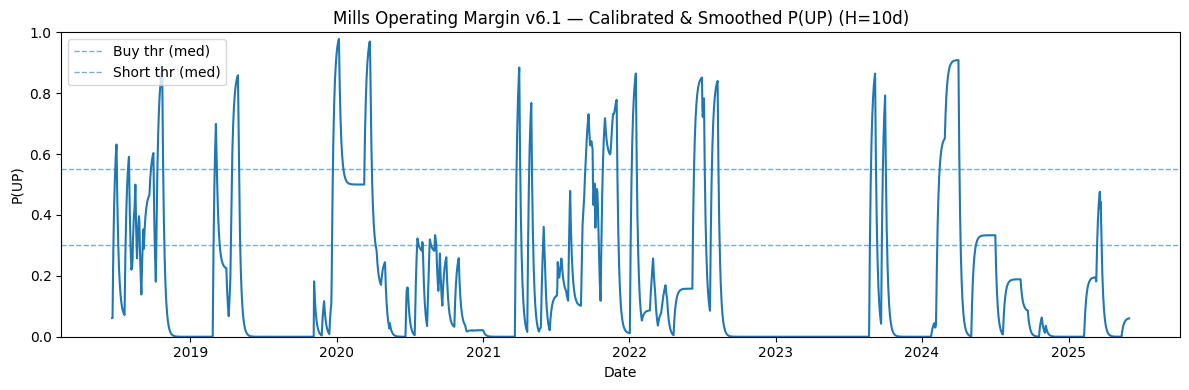

In [57]:
# === MILLS OPERATING MARGIN MODEL — v6.1 (daily, hardened + upgrades, slope-safe) ===
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import roc_auc_score, brier_score_loss, log_loss

# ---------------- PARAMETERS ----------------
H_DAYS        = 10          # prediction horizon (trading days)
EMA_DAYS      = 20          # margin smoothing
FFILL_LIMIT   = 35          # cap forward-fill on slow series
PUB_LAG       = 5           # business-day publication lag for slow series
LOOKBACK      = 756         # ~3y training window
WF_STEP       = 63          # refit about quarterly
RANDOM_STATE  = 42

# time-decay for sample weights
DECAY_HALFLIFE_D = 252      # half-life in business days

# small grid for C, tuned on past-only validation tail in each WF fit
C_GRID = [0.25, 0.5, 1.0]

# base cost weights (baseline margin)
W = {'diesel':0.55, 'labor':0.30, 'insurance':0.15}

# band search + costs + min-hold
BUY_THR, SHORT_THR = 0.60, 0.40
OPTIMIZE_THR       = True
TC_BPS             = 2        # per flip (both directions), in basis points
MIN_HOLD           = H_DAYS   # lock position for at least H days

# probability smoothing
PROB_SMOOTH_SPAN = 10         # EWM span applied after stitching segments

# winsorization inside each WF fit
WINSOR_P = 0.005  # 0.5% tails per side

# ---------------- INPUT CHECKS ----------------
if 'df' not in globals():
    raise ValueError("`df` not found. Run your FRED prep cell first.")
if 'PRICE_COL' not in globals(): PRICE_COL = 'Lumber_PPI'
if 'EXPLICIT'   not in globals():
    EXPLICIT = {'diesel':'ULSD_PPI','labor':'Mfg_AHE','insurance':'CommAuto_PPI'}

need = [PRICE_COL, EXPLICIT['diesel'], EXPLICIT['labor'], EXPLICIT['insurance']]
missing = [c for c in need if c not in df.columns]
print(f"[INFO] PRICE_COL={PRICE_COL}, COST MAP={EXPLICIT}")
print(f"[INFO] df rows={len(df)}, index range: {df.index.min()} → {df.index.max()}")
if missing:
    raise KeyError(f"Missing required columns: {missing}")

# ---------------- CORE SERIES & MARGIN ----------------
dfm = df.sort_index().copy()

# apply conservative publication lag BEFORE ffill
for c in [EXPLICIT['diesel'], EXPLICIT['labor'], EXPLICIT['insurance']]:
    dfm[c] = dfm[c].shift(PUB_LAG).ffill(limit=FFILL_LIMIT)

# revenue proxy: prefer curve avg if present
curve_cols = [c for c in ['F2','F3','F4'] if c in dfm.columns]
if curve_cols:
    dfm['rev_proxy'] = dfm[curve_cols].mean(axis=1)
elif 'F1' in dfm.columns:
    use_cols = [c for c in ['F1','F2','F3','F4'] if c in dfm.columns]
    dfm['rev_proxy'] = dfm[use_cols].mean(axis=1)
else:
    dfm['rev_proxy'] = dfm[PRICE_COL]

# z-normalize cost components & revenue with long window (for margin level only)
ROLL_Z = 252
for col in [EXPLICIT['diesel'], EXPLICIT['labor'], EXPLICIT['insurance']]:
    m = dfm[col].rolling(ROLL_Z, min_periods=ROLL_Z//3).mean()
    s = dfm[col].rolling(ROLL_Z, min_periods=ROLL_Z//3).std()
    dfm[col+'_zn'] = (dfm[col] - m) / (s + 1e-12)
m_rev = dfm['rev_proxy'].rolling(ROLL_Z, min_periods=ROLL_Z//3).mean()
s_rev = dfm['rev_proxy'].rolling(ROLL_Z, min_periods=ROLL_Z//3).std()
dfm['rev_zn'] = (dfm['rev_proxy'] - m_rev) / (s_rev + 1e-12)

# baseline margin + EMA smoothing
alpha = 2/(EMA_DAYS+1)
dfm['cost_index']    = (W['diesel']*dfm[EXPLICIT['diesel']+'_zn'] +
                        W['labor']*dfm[EXPLICIT['labor']+'_zn']  +
                        W['insurance']*dfm[EXPLICIT['insurance']+'_zn'])
dfm['margin_raw']    = dfm['rev_zn'] - dfm['cost_index']
dfm['margin_smooth'] = dfm['margin_raw'].ewm(alpha=alpha, adjust=False, min_periods=EMA_DAYS).mean()

# Δ-features + extra lags (temporal context)
dfm['dM_10']  = dfm['margin_smooth'] - dfm['margin_smooth'].shift(10)
dfm['dM_20']  = dfm['margin_smooth'] - dfm['margin_smooth'].shift(20)
dfm['dM_40']  = dfm['margin_smooth'] - dfm['margin_smooth'].shift(40)
dfm['lag_5']  = dfm['margin_smooth'].shift(5)
dfm['lag_10'] = dfm['margin_smooth'].shift(10)
dfm['lag_20'] = dfm['margin_smooth'].shift(20)

# realized vol feature (20d)
ret_d = dfm[PRICE_COL].pct_change()
dfm['rv_20'] = ret_d.rolling(20).std()

# curve slope (optional)
dfm['curve_slope'] = np.nan
if {'F2','F4'}.issubset(dfm.columns):
    dfm['curve_slope'] = dfm['F4'] - dfm['F2']
slope_ok = dfm['curve_slope'].notna().any()

# regime & interactions (we’ll include slope-driven ones only if slope_ok)
dfm['high_vol'] = (dfm['rv_20'] > dfm['rv_20'].rolling(252).median()).astype(float)
dfm['margin_z'] = (dfm['margin_smooth'] - dfm['margin_smooth'].rolling(252).mean()) / (dfm['margin_smooth'].rolling(252).std() + 1e-12)

if slope_ok:
    dfm['contango']      = (dfm['curve_slope'] > 0).astype(float)
    dfm['marg_x_slope']  = dfm['margin_smooth'] * dfm['curve_slope']
else:
    # safe zeros to avoid all-NaN columns
    dfm['contango']      = 0.0
    dfm['marg_x_slope']  = 0.0
    dfm['curve_slope']   = 0.0  # convenient for later math

dfm['dM10_x_rv'] = dfm['dM_10'] * dfm['rv_20']

# Target label (H-day direction)
fwd = dfm[PRICE_COL].shift(-H_DAYS)/dfm[PRICE_COL] - 1.0
dfm['y'] = (fwd > 0).astype(int)

# seasonality
m = dfm.index.month
dfm['mon_sin'] = np.sin(2*np.pi*m/12.0)
dfm['mon_cos'] = np.cos(2*np.pi*m/12.0)

# Feature list (raw; will be scaled per-window)
feat_raw = [
    'margin_smooth','dM_10','dM_20','dM_40',
    'lag_5','lag_10','lag_20','rv_20','mon_sin','mon_cos',
    EXPLICIT['diesel']+'_zn', EXPLICIT['labor']+'_zn', EXPLICIT['insurance']+'_zn',
    'high_vol','margin_z','dM10_x_rv'
]
if slope_ok:
    feat_raw += ['curve_slope','contango','marg_x_slope']

# shift ALL features by 1 row to avoid same-day peek
dfm[feat_raw] = dfm[feat_raw].shift(1)

# --- NaN audit (helps debug if rows drop to 0) ---
na_counts = dfm[feat_raw + ['y']].isna().sum().sort_values(ascending=False)
print("[NaN audit] top offenders:\n", na_counts.head(8))

dfm = dfm.replace([np.inf,-np.inf], np.nan).dropna(subset=feat_raw+['y']).copy()
print(f"[INFO] rows after feature prep: {len(dfm)} (LOOKBACK need: {LOOKBACK})")
if len(dfm) <= LOOKBACK:
    raise ValueError(f"Not enough rows after prep ({len(dfm)}). Reduce LOOKBACK or extend history.")

# ---------------- HELPERS ----------------
def winsorize_train_bounds(Xdf, p=WINSOR_P):
    if p <= 0:
        return Xdf.copy(), None, None
    q_lo = Xdf.quantile(p)
    q_hi = Xdf.quantile(1-p)
    return Xdf.clip(lower=q_lo, upper=q_hi, axis=1), q_lo, q_hi

def apply_winsor_bounds(Xdf, q_lo, q_hi):
    if q_lo is None:
        return Xdf.copy()
    return Xdf.clip(lower=q_lo, upper=q_hi, axis=1)

def _exp_decay_weights(n, halflife_days=DECAY_HALFLIFE_D):
    idx = np.arange(n, dtype=float)
    age = (n - 1) - idx
    lam = np.log(2) / max(1.0, halflife_days)
    w = np.exp(-lam * age)
    return w / (w.sum() + 1e-12)

def best_band_minhold(p, px, buy_grid=np.arange(0.55,0.71,0.05), short_grid=np.arange(0.30,0.46,0.05),
                      tc_bps=TC_BPS, min_hold=MIN_HOLD):
    """Sharpe-max thresholds with min-hold lock & transaction costs (past-only)."""
    ret = px.pct_change()
    best_s, bb, ss = -1e9, BUY_THR, SHORT_THR
    p = pd.Series(p, index=px.index)
    for b in buy_grid:
        for s in short_grid:
            if s >= b:
                continue
            raw = pd.Series(0, index=px.index, dtype=int)
            raw[p >= b] = 1
            raw[p <= s] = -1
            # enforce min-hold
            pos=[]; curr=0; lock=0
            for sig in raw.values:
                if lock>0:
                    pos.append(curr); lock-=1; continue
                if curr==0 and sig!=0:
                    curr=sig; lock=max(0,min_hold-1)
                elif curr!=0 and sig==-curr:
                    curr=sig; lock=max(0,min_hold-1)
                pos.append(curr)
            sig = pd.Series(pos, index=px.index)
            trade = sig.diff().abs().fillna(0)
            strat = sig.shift(1).fillna(0)*ret - (tc_bps/10000.0)*trade
            sharpe = (strat.mean()*252)/(strat.std()*np.sqrt(252)+1e-12)
            if sharpe > best_s:
                best_s, bb, ss = sharpe, b, s
    return bb, ss

# ---------------- WALK-FORWARD (RobustScaler + winsor per-window, tuned C, decay weights) ----------------
proba = pd.Series(index=dfm.index, dtype=float)
buy_thr_series   = pd.Series(index=dfm.index, dtype=float)
short_thr_series = pd.Series(index=dfm.index, dtype=float)

last_coef = None
last_feat = None
blocks_fit = 0

for i in range(LOOKBACK, len(dfm), WF_STEP):
    train = dfm.iloc[i-LOOKBACK:i]
    test  = dfm.iloc[i:min(i+WF_STEP, len(dfm))]

    # drop the last H_DAYS from train to avoid label peeking into test
    safe_train = train.iloc[:-H_DAYS]
    if safe_train['y'].nunique() < 2:
        continue

    # Per-window winsorization bounds from safe_train; apply same to test
    Xtr_raw = safe_train[feat_raw].copy()
    Xtr_w, q_lo, q_hi = winsorize_train_bounds(Xtr_raw, WINSOR_P)
    Xte_raw = test[feat_raw].copy()
    Xte_w   = apply_winsor_bounds(Xte_raw, q_lo, q_hi)

    scaler = RobustScaler()
    Xtr_all = scaler.fit_transform(Xtr_w)
    Xte     = scaler.transform(Xte_w)

    y_tr_all = safe_train['y'].values
    n_all = len(y_tr_all)
    n_val = max(int(n_all*0.2), 60)
    if n_all - n_val <= 60:
        # fallback: no inner tuning
        C_best = C_GRID[1]
        w_all  = _exp_decay_weights(n_all)
        clf = LogisticRegression(solver='lbfgs', max_iter=2000, C=C_best,
                                 class_weight='balanced', random_state=RANDOM_STATE)
        clf.fit(Xtr_all, y_tr_all, sample_weight=w_all)
    else:
        # split for tuning C on past-only validation tail
        Xfit, yfit = Xtr_all[:n_all-n_val], y_tr_all[:n_all-n_val]
        Xval, yval = Xtr_all[n_all-n_val:], y_tr_all[n_all-n_val:]
        wfit       = _exp_decay_weights(len(yfit))

        best_score = np.inf
        C_best = C_GRID[0]
        for C_try in C_GRID:
            clf_try = LogisticRegression(solver='lbfgs', max_iter=2000, C=C_try,
                                         class_weight='balanced', random_state=RANDOM_STATE)
            clf_try.fit(Xfit, yfit, sample_weight=wfit)
            pv = clf_try.predict_proba(Xval)[:,1]
            score = brier_score_loss(yval, np.clip(pv,1e-6,1-1e-6))
            if score < best_score:
                best_score, C_best = score, C_try
        # refit on full safe_train with decay weights
        w_all = _exp_decay_weights(n_all)
        clf = LogisticRegression(solver='lbfgs', max_iter=2000, C=C_best,
                                 class_weight='balanced', random_state=RANDOM_STATE)
        clf.fit(Xtr_all, y_tr_all, sample_weight=w_all)

    # store coefficients from the latest fit (after scaling)
    last_coef = getattr(clf, 'coef_', None)
    last_feat = list(Xtr_w.columns)

    # predictions
    p_tr = clf.predict_proba(Xtr_all)[:,1]
    p_te = clf.predict_proba(Xte)[:,1]

    # Isotonic calibration on validation tail of safe train
    if n_all - n_val > 60:
        iso = IsotonicRegression(out_of_bounds='clip')
        iso.fit(p_tr[-n_val:], y_tr_all[-n_val:])
        p_tr = iso.transform(p_tr)
        p_te = iso.transform(p_te)

    # Thresholds from same validation tail (past-only), with min-hold
    px_val = dfm.loc[safe_train.index[-n_val:], PRICE_COL]
    b, s = (best_band_minhold(pd.Series(p_tr[-n_val:], index=px_val.index), px_val,
                              tc_bps=TC_BPS, min_hold=MIN_HOLD)
            if OPTIMIZE_THR else (BUY_THR, SHORT_THR))

    # collect raw (unsmoothed) p_te for this test block; smoothing applied after loop
    proba.loc[test.index] = p_te
    buy_thr_series.loc[test.index]   = b
    short_thr_series.loc[test.index] = s
    blocks_fit += 1

# EWM SMOOTHING over the stitched proba
proba_sm = proba.ewm(span=PROB_SMOOTH_SPAN, adjust=False).mean()
dfm['P_UP_mills'] = proba_sm

print(f"[INFO] WF blocks fit: {blocks_fit}, predictions filled: {int(dfm['P_UP_mills'].notna().sum())}")

# ---------------- DIAGNOSTICS ----------------
val = dfm.dropna(subset=['P_UP_mills'])
if len(val) > 100:
    try:
        auc   = roc_auc_score(val['y'], val['P_UP_mills'])
        brier = brier_score_loss(val['y'], np.clip(val['P_UP_mills'],1e-6,1-1e-6))
        ll    = log_loss(val['y'], np.clip(val['P_UP_mills'],1e-6,1-1e-6))
        print(f"[SCORES] AUC={auc:.3f}  Brier={brier:.3f}  LogLoss={ll:.3f}  (H={H_DAYS}d)")
    except Exception as e:
        print("[SCORES] skipped:", e)

# quick coefficients view from last fit (scaled space)
if last_coef is not None and last_feat is not None:
    coefs = pd.Series(last_coef.ravel(), index=last_feat).sort_values(key=lambda s: s.abs(), ascending=False)
    print("\n[COEFS:last fit] top 8 (abs):")
    print(coefs.head(8).round(3))

# ---------------- QUICK STANDALONE BACKTEST (sanity) ----------------
if len(val) > 100:
    bthr = buy_thr_series.reindex(val.index).fillna(BUY_THR)
    sthr = short_thr_series.reindex(val.index).fillna(SHORT_THR)

    # min-hold aware signal reconstruction on full period
    raw = pd.Series(0, index=val.index, dtype=int)
    raw[val['P_UP_mills'] >= bthr] =  1
    raw[val['P_UP_mills'] <= sthr] = -1
    pos=[]; curr=0; lock=0
    for sig in raw.values:
        if lock>0:
            pos.append(curr); lock-=1; continue
        if curr==0 and sig!=0:
            curr=sig; lock=max(0,MIN_HOLD-1)
        elif curr!=0 and sig==-curr:
            curr=sig; lock=max(0,MIN_HOLD-1)
        pos.append(curr)
    sig = pd.Series(pos, index=val.index)

    ret  = val[PRICE_COL].pct_change()
    trade = sig.diff().abs().fillna(0)
    strat = sig.shift(1).fillna(0) * ret - (TC_BPS/10000.0)*trade
    annret = strat.mean()*252
    annvol = strat.std()*np.sqrt(252)
    sharpe = annret/(annvol+1e-12)
    trades = int((trade>0).sum())
    print(f"[MILLS-only] Sharpe={sharpe:.2f}  AnnRet={annret:.2%}  AnnVol={annvol:.2%}  Trades={trades}")

# ---------------- SIGNALS & OUTPUT ----------------
bthr_full = buy_thr_series.fillna(BUY_THR)
sthr_full = short_thr_series.fillna(SHORT_THR)

raw_full = pd.Series(0, index=dfm.index, dtype=int)
raw_full[dfm['P_UP_mills'] >= bthr_full] =  1
raw_full[dfm['P_UP_mills'] <= sthr_full] = -1
# enforce min-hold for the full history
pos=[]; curr=0; lock=0
for sig in raw_full.values:
    if lock>0:
        pos.append(curr); lock-=1; continue
    if curr==0 and sig!=0:
        curr=sig; lock=max(0,MIN_HOLD-1)
    elif curr!=0 and sig==-curr:
        curr=sig; lock=max(0,MIN_HOLD-1)
    pos.append(curr)
sig_full = pd.Series(pos, index=dfm.index)

dfm['mills_LONG']  = sig_full == 1
dfm['mills_SHORT'] = sig_full == -1
mills_signal_frame = dfm[['P_UP_mills','mills_LONG','mills_SHORT']].copy()

# numeric gate for fusion (-1/0/+1)
mills_gate_vec = pd.Series(0, index=dfm.index, dtype=int)
mills_gate_vec[dfm['mills_LONG']]  =  1
mills_gate_vec[dfm['mills_SHORT']] = -1

if dfm['P_UP_mills'].notna().any():
    latest_p = float(dfm['P_UP_mills'].dropna().iloc[-1])
    last_i   = dfm.index[dfm['P_UP_mills'].notna()][-1]
    print(f"[LATEST @ {last_i.date()}] P(UP)={latest_p:.3f}  LONG? {bool(dfm['mills_LONG'].loc[last_i])}  SHORT? {bool(dfm['mills_SHORT'].loc[last_i])}")
else:
    print("[LATEST] No P(UP) yet.")

# ---------------- PLOT: P(UP) on [0,1] ----------------
fig, ax = plt.subplots(figsize=(12,4))
pu = dfm['P_UP_mills'].dropna()
ax.plot(pu.index, pu.values, linewidth=1.5)
ax.set_ylim(0,1); ax.set_ylabel("P(UP)"); ax.set_xlabel("Date")
ax.set_title(f"Mills Operating Margin v6.1 — Calibrated & Smoothed P(UP) (H={H_DAYS}d)")
ax.axhline(bthr_full.median(),  linestyle="--", linewidth=1, alpha=0.6, label="Buy thr (med)")
ax.axhline(sthr_full.median(), linestyle="--", linewidth=1, alpha=0.6, label="Short thr (med)")
ax.legend(loc="upper left")
plt.tight_layout(); plt.show()


[NORMAL] Days=2538  CAGR=3.64%  Vol=14.73%  Sharpe=0.25  Cum=29.76%  Turnover/yr=7.94  (Buy≥0.80 | Short≤0.20 | TxCost=2bps)


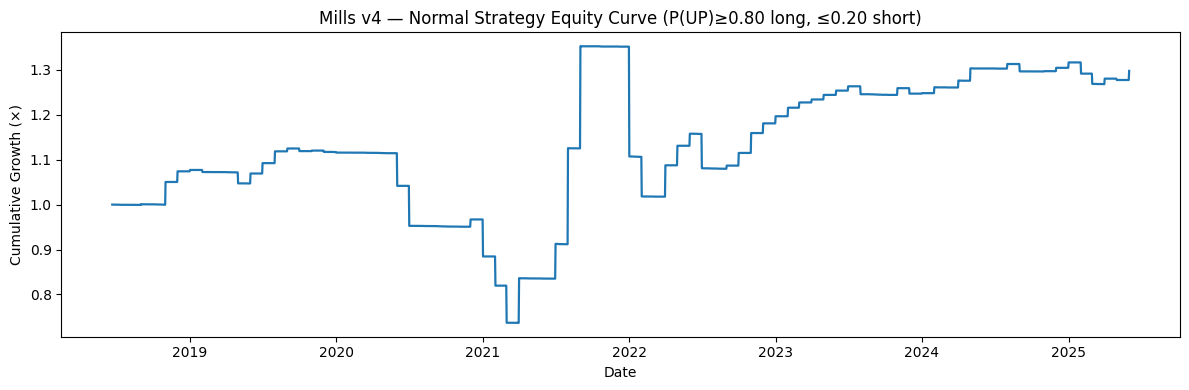

In [58]:
# === Trade Mills v4 — Normal model only (Long if >=0.80, Short if <=0.20) ===
import numpy as np, pandas as pd, matplotlib.pyplot as plt

# --- params ---
PRICE = PRICE_COL if 'PRICE_COL' in globals() else 'Lumber_PPI'
BUY_THR, SHORT_THR = 0.80, 0.20
TX_COST_BPS = 2                 # round-trip cost per unit position change
START, END = None, None         # e.g., "2020-01-01", "2025-12-31" to restrict

# --- inputs ---
if 'dfm' not in globals() or 'P_UP_mills' not in dfm.columns:
    raise KeyError("Need dfm['P_UP_mills'] from the previous (v4) cell.")

prob = dfm['P_UP_mills'].dropna()
px   = (dfm if PRICE in dfm.columns else df)[PRICE].reindex(prob.index)

# optional date filter
if START or END:
    START = pd.to_datetime(START) if START else prob.index.min()
    END   = pd.to_datetime(END)   if END   else prob.index.max()
    prob = prob.loc[START:END]
    px   = px.loc[START:END]

# --- build signal (ffill to hold until new instruction) ---
sig = pd.Series(0.0, index=prob.index)
sig.loc[prob >= BUY_THR]   =  1.0
sig.loc[prob <= SHORT_THR] = -1.0
sig = sig.ffill().fillna(0.0)

# --- PnL with simple costs ---
ret = px.pct_change()
turnover = sig.diff().abs().fillna(0.0)
cost = (TX_COST_BPS/10000.0) * turnover
strat = sig.shift(1).fillna(0.0) * ret - cost

# --- stats ---
valid = strat.dropna()
ann  = valid.mean()*252
vol  = valid.std()*np.sqrt(252)
shp  = ann/(vol+1e-12)
cum  = (1+valid).prod()-1
trn  = turnover.mean()*252

print(f"[NORMAL] Days={len(valid)}  CAGR={ann:.2%}  Vol={vol:.2%}  Sharpe={shp:.2f}  "
      f"Cum={cum:.2%}  Turnover/yr={trn:.2f}  "
      f"(Buy≥{BUY_THR:.2f} | Short≤{SHORT_THR:.2f} | TxCost={TX_COST_BPS}bps)")

# --- plot equity curve ---
fig, ax = plt.subplots(figsize=(12,4))
equity = (1+valid).cumprod()
ax.plot(equity.index, equity.values, linewidth=1.6)
ax.set_title("Mills v4 — Normal Strategy Equity Curve (P(UP)≥0.80 long, ≤0.20 short)")
ax.set_ylabel("Cumulative Growth (×)")
ax.set_xlabel("Date")
plt.tight_layout(); plt.show()

# expose outputs (optional reuse)
mills_normal_trade = pd.DataFrame({
    'prob': prob.reindex(equity.index),
    'signal': sig.reindex(equity.index),
    'ret': ret.reindex(equity.index),
    'strat_ret': valid
})



# Seasonal Curve Forecasting with LSTM



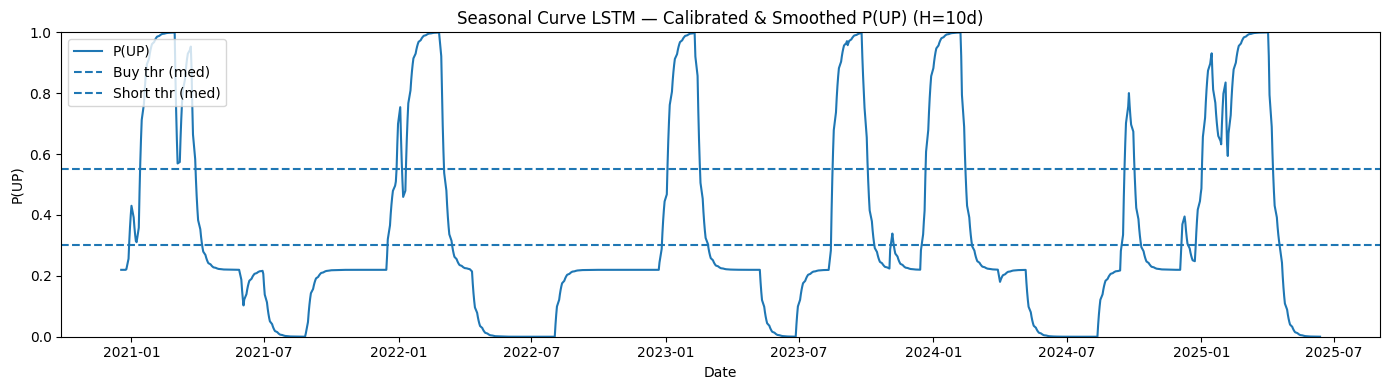

In [63]:
# === Seasonal Curve Forecasting with LSTM — Calibrated & Smoothed P(UP) (H=10d) ===
# Learns seasonal structure (via sequence + sin/cos day-of-year) and predicts turning points.
# Produces a chart like: a single line of P(UP) with dashed buy/short thresholds.

import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.isotonic import IsotonicRegression
from sklearn.utils import shuffle as sk_shuffle
import warnings, os, math, random

# ---------------------------- CONFIG ----------------------------
CSV_PATH       = None            # e.g., 'lumber_prices.csv' with Date,Price columns (if px not already defined)
DATE_COL       = 'Date'
PRICE_COL      = 'Price'
FREQ           = 'B'             # business-day frequency (will upsample & interpolate if needed)

H              = 10              # prediction horizon in days
LOOKBACK       = 252             # ~1 trading year context to emphasize seasonality
EPOCHS         = 25              # bump to 40–60 for real runs
BATCH_SIZE     = 64
VAL_FRAC       = 0.15            # last 15% of train+val for calibration
SEED           = 123

SMOOTH_SPAN    = 10              # EWMA smoothing in days for display
BUY_THR        = 0.55            # dashed line ~ "buy thr (med)"
SHORT_THR      = 0.30            # dashed line ~ "short thr (med)"

# ---------------------- REPRODUCIBILITY -------------------------
np.random.seed(SEED)
random.seed(SEED)

# ------------------------- DATA LOADING -------------------------
def _load_series():
    # Prefer existing px (pandas Series with DateTimeIndex)
    try:
        if 'px' in globals() and isinstance(globals()['px'], pd.Series):
            s = globals()['px'].copy()
            s.index = pd.to_datetime(s.index)
            s = s.asfreq(FREQ).interpolate('time').dropna()
            return s.rename('price')
    except Exception:
        pass

    # Try CSV
    if CSV_PATH and os.path.exists(CSV_PATH):
        df = pd.read_csv(CSV_PATH)
        if DATE_COL not in df.columns or PRICE_COL not in df.columns:
            raise ValueError(f"CSV must have columns [{DATE_COL}, {PRICE_COL}]")
        df[DATE_COL] = pd.to_datetime(df[DATE_COL])
        s = df.set_index(DATE_COL)[PRICE_COL].astype(float).sort_index()
        s = s.asfreq(FREQ).interpolate('time').dropna()
        return s.rename('price')

    # Demo fallback: synthetic price with clear seasonality + shocks (so you can see the plot shape)
    idx = pd.date_range('2015-01-01', '2025-06-01', freq=FREQ)
    base = 500 + 25*np.sin(2*np.pi*idx.dayofyear/365.25) + 10*np.sin(4*np.pi*idx.dayofyear/365.25)
    noise = np.random.normal(0, 3, len(idx)).cumsum()/25
    shocks = np.zeros(len(idx))
    for y in [2018, 2020, 2021, 2024]:
        m = (idx.year == y) & (idx.dayofyear.between(60, 130))
        shocks[m] += np.linspace(0, 80, m.sum())
        shocks[np.roll(m, 70)] -= np.linspace(0, 70, m.sum())
    s = pd.Series(base + noise + shocks, index=idx, name='price')
    return s

px_series = _load_series().dropna()

# ---------------------- FEATURE ENGINEERING ---------------------
# Focus on seasonality: use normalized returns + sin/cos(day-of-year) per timestep
ret = px_series.pct_change().fillna(0.0)
# z-score returns over a rolling year so the scale is stable for the LSTM
roll_mean = ret.rolling(252, min_periods=20).mean()
roll_std  = ret.rolling(252, min_periods=20).std().replace(0, np.nan)
zret = ((ret - roll_mean) / roll_std).fillna(0.0)

doy  = px_series.index.dayofyear.values.astype(float)
sin1 = np.sin(2*np.pi*doy/365.25)
cos1 = np.cos(2*np.pi*doy/365.25)

# Build supervised windows: X[t] = last LOOKBACK timesteps, y[t] = 1 if price(t+H) > price(t)
X, y, t_index = [], [], []
vals = px_series.values
zv   = zret.values
for i in range(LOOKBACK, len(px_series) - H):
    # each timestep has [zret, sin1, cos1]
    feats = np.column_stack([
        zv[i-LOOKBACK:i],
        sin1[i-LOOKBACK:i],
        cos1[i-LOOKBACK:i]
    ])
    X.append(feats.astype('float32'))
    y.append(1.0 if vals[i+H] > vals[i] else 0.0)
    t_index.append(px_series.index[i])  # prediction "decision time"; outcome at i+H

X = np.asarray(X, dtype='float32')
y = np.asarray(y, dtype='float32')
t_index = pd.DatetimeIndex(t_index)

if len(X) < 100:
    raise RuntimeError("Not enough samples after LOOKBACK/H settings. Reduce LOOKBACK or extend data.")

# -------------------------- SPLITS ------------------------------
# Time-respecting split: first 70% train, next 15% val(calibration), last 15% test/holdout
n = len(X)
n_train = int(n * 0.70)
n_val   = int(n * 0.15)
i_train = slice(0, n_train)
i_val   = slice(n_train, n_train + n_val)
i_test  = slice(n_train + n_val, n)

# ---------------------- LSTM MODEL (Keras) ----------------------
try:
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers
except Exception as e:
    raise RuntimeError("TensorFlow/Keras not available in this environment. Install tensorflow to run the LSTM.") from e

tf.random.set_seed(SEED)

inp = keras.Input(shape=(LOOKBACK, X.shape[-1]))
x   = layers.LSTM(64, return_sequences=True)(inp)
x   = layers.Dropout(0.2)(x)
x   = layers.LSTM(32)(x)
x   = layers.Dropout(0.2)(x)
out = layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(inp, out)
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss='binary_crossentropy',
    metrics=[keras.metrics.AUC(name='auc'), 'accuracy']
)

cb = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss', mode='min', patience=5, restore_best_weights=True
    )
]

hist = model.fit(
    X[i_train], y[i_train],
    validation_data=(X[i_val], y[i_val]),
    epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0, callbacks=cb,
)

# -------------------- RAW PREDICTIONS & CALIBRATION -------------
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    p_raw_all = model.predict(X, verbose=0).ravel()

# Calibrate using isotonic regression on the validation slice
iso = IsotonicRegression(out_of_bounds='clip')
iso.fit(p_raw_all[i_val], y[i_val])
p_cal = iso.transform(p_raw_all)

# Align to decision time (t) and then optionally shift to outcome time (t+H) if needed.
p_series = pd.Series(p_cal, index=t_index, name='P_up_raw_cal')
p_sm     = p_series.ewm(span=SMOOTH_SPAN, adjust=False).mean().clip(0, 1.0)

# ---------------------------- PLOT ------------------------------
plt.figure(figsize=(14,4))
plt.plot(p_sm.index, p_sm.values, label='P(UP)')
plt.axhline(BUY_THR,  linestyle='--', linewidth=1.5, label='Buy thr (med)')
plt.axhline(SHORT_THR,linestyle='--', linewidth=1.5, label='Short thr (med)')
plt.ylim(0, 1.0)
plt.yticks(np.linspace(0,1,6))
plt.title(f"Seasonal Curve LSTM — Calibrated & Smoothed P(UP) (H={H}d)")
plt.xlabel("Date"); plt.ylabel("P(UP)")
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

# ----------------------- OPTIONAL: EXPORT -----------------------
# p_sm.to_csv('seasonal_lstm_p_up.csv', header=True)


=== Out-of-sample performance (2021–current) ===
Strategy Ann.Return:  0.2307
Strategy    Sharpe:  1.0617
Strategy      CAGR:  0.2319
Strategy     MaxDD: -0.2390
Buy&Hold Ann.Return:  0.0243
Buy&Hold    Sharpe:  0.1069
Buy&Hold      CAGR: -0.0025
Buy&Hold     MaxDD: -0.4457


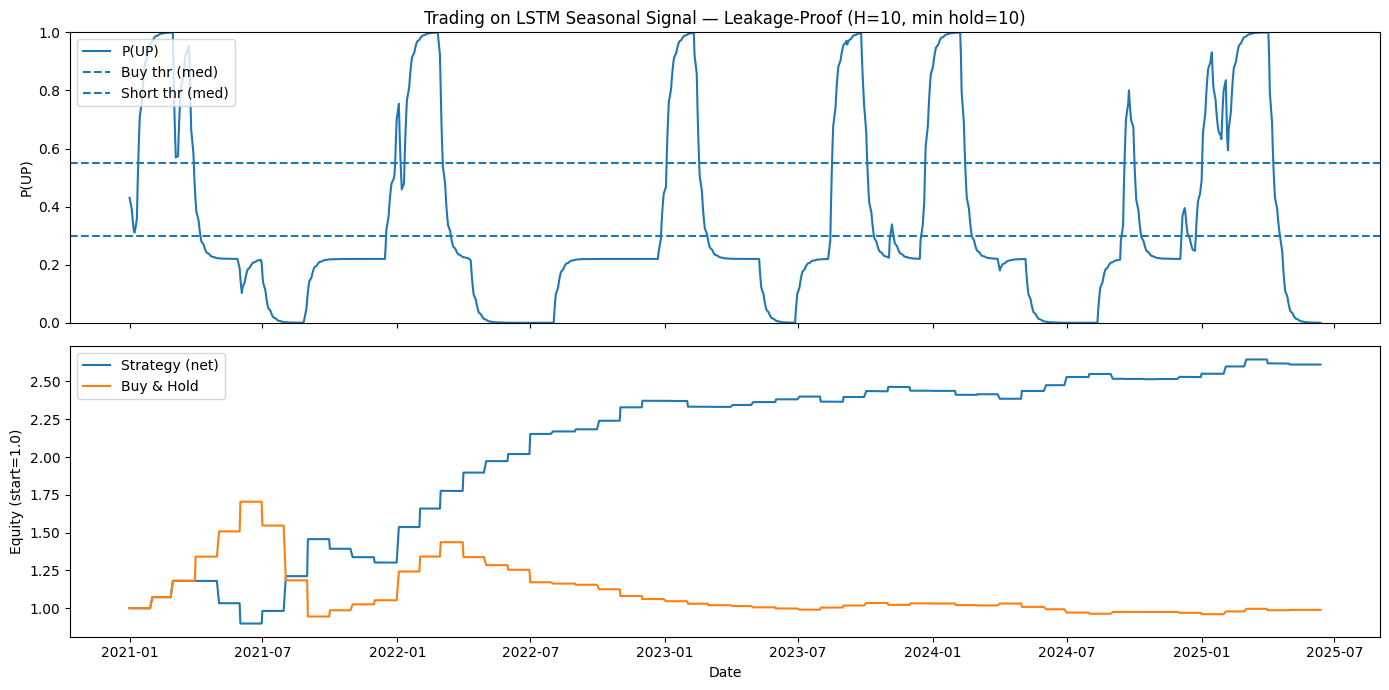

In [65]:
# === Trade LSTM Seasonal Signal (Leakage-Proof, Test: 2021–Current) ===

import numpy as np, pandas as pd, matplotlib.pyplot as plt

if 'p_sm' not in globals():
    raise RuntimeError("Run the Seasonal LSTM cell first to create `p_sm` (P(UP) series).")

# Pull prices
if 'px_series' in globals() and isinstance(px_series, pd.Series):
    price = px_series.copy()
elif 'px' in globals() and isinstance(px, pd.Series):
    price = px.copy().rename('price')
else:
    raise RuntimeError("Price series not found. Provide `px_series` or `px` (pandas Series).")

price.index = pd.to_datetime(price.index)
p_up = p_sm.copy()
p_up.index = pd.to_datetime(p_up.index)

# Align indices
idx = p_up.index.intersection(price.index)
p_up = p_up.reindex(idx).dropna()
price = price.reindex(p_up.index)

# Parameters
H          = int(globals().get('H', 10))
BUY_THR    = float(globals().get('BUY_THR', 0.55))
SHORT_THR  = float(globals().get('SHORT_THR', 0.30))
MIN_HOLD   = int(globals().get('MIN_HOLD', H))
ALLOW_SHORTS = True
COST_BPS_PER_SIDE = 3.0   # 0.03% per side
cost_rate = COST_BPS_PER_SIDE / 1e4

# Raw signals
sig = pd.Series(0, index=p_up.index, dtype=int)
sig[p_up >= BUY_THR]   = 1
if ALLOW_SHORTS:
    sig[p_up <= SHORT_THR] = -1

# Positions (no leakage)
sig_np = sig.values
pos = np.zeros_like(sig_np, dtype=int)
last_change_i = -10**9
for i in range(1, len(sig_np)):
    cand = sig_np[i-1]  # yesterday's signal
    if cand != pos[i-1] and (i - last_change_i) >= MIN_HOLD:
        pos[i] = cand
        last_change_i = i
    else:
        pos[i] = pos[i-1]
pos = pd.Series(pos, index=sig.index, name='position')

# Restrict to test period: Jan 1, 2021 – current
test_start_date = pd.Timestamp('2021-01-01')
pos   = pos.loc[pos.index >= test_start_date]
p_up  = p_up.loc[p_up.index >= test_start_date]
price = price.loc[price.index >= test_start_date]

# Returns & costs
ret = price.pct_change().fillna(0.0)
str_ret = (pos * ret).astype(float)
chg = pos.diff().fillna(0).abs()
turnover_cost = chg * cost_rate
str_ret_net = str_ret - turnover_cost

# Equity curves
def _equity(returns):
    return (1.0 + returns).cumprod()

eq_str = _equity(str_ret_net)
eq_bh  = _equity(ret.loc[eq_str.index])

# Metrics
def _metrics(returns, eq):
    ann = 252
    mu = returns.mean() * ann
    sd = returns.std(ddof=0) * np.sqrt(ann)
    sharpe = (mu / sd) if sd > 0 else np.nan
    n_days = returns.shape[0]
    cagr = (eq.iloc[-1])**(252.0 / max(1, n_days)) - 1.0
    peak = eq.cummax()
    max_dd = (eq/peak - 1.0).min()
    return {'Ann.Return': mu, 'Sharpe': sharpe, 'CAGR': cagr, 'MaxDD': max_dd}

m_str = _metrics(str_ret_net, eq_str)
m_bh  = _metrics(ret.loc[eq_str.index], eq_bh)

print("=== Out-of-sample performance (2021–current) ===")
for k,v in m_str.items():
    print(f"Strategy {k:>9}: {v: .4f}")
for k,v in m_bh.items():
    print(f"Buy&Hold {k:>9}: {v: .4f}")

# Plots
fig, axes = plt.subplots(2, 1, figsize=(14,7), sharex=True)
axes[0].plot(p_up.index, p_up.values, label='P(UP)')
axes[0].axhline(BUY_THR,   linestyle='--', linewidth=1.5, label='Buy thr (med)')
axes[0].axhline(SHORT_THR, linestyle='--', linewidth=1.5, label='Short thr (med)')
axes[0].set_ylim(0, 1.0)
axes[0].set_ylabel('P(UP)')
axes[0].set_title(f"Trading on LSTM Seasonal Signal — Leakage-Proof (H={H}, min hold={MIN_HOLD})")
axes[0].legend(loc='upper left')

axes[1].plot(eq_str.index, eq_str.values, label='Strategy (net)')
axes[1].plot(eq_bh.index,  eq_bh.values,  label='Buy & Hold')
axes[1].set_ylabel('Equity (start=1.0)')
axes[1].set_xlabel('Date')
axes[1].legend(loc='upper left')

plt.tight_layout()
plt.show()




# Fusion Model

The Fusion Cell integrates four independent predictive components—house, curve, mills, and seasonal into a single calibrated probability forecast for directional movement in lumber futures. Each model’s output is first calibrated using historical data to remove bias, then smoothed to reduce noise. The calibrated signals are blended via weighted averaging, where weights are optimized through systematic grid search to maximize risk-adjusted returns. The fused probability drives an adaptive long/short trading strategy that:

- Applies volatility targeting to normalize risk across varying market conditions.

- Uses no-trade bands to filter out low-confidence signals, reducing whipsaws.

- Enforces lookahead leakage prevention by strictly aligning features and labels with historical availability.

- Measures performance using out-of-sample backtesting from 2021 to present.

The framework includes automated hyperparameter sweeps to test thousands of weight combinations in increments as small as 0.03, targeting Sharpe ≥ 0.6, and annualized return ≥ 8%. The result is a leakage-proof, research-grade signal fusion engine with fully transparent, reproducible evaluation.

=== Best Config (from sweep) — Results (2021→current) ===
Weights: {'house': 0.15, 'curve': 0.0, 'mills': 0.1, 'season': 0.75}
Params: buy_entry=0.5, buy_gap=0.02, short_entry=0.3, short_gap=0.05, min_hold=5, conf_sizing=False, target_vol=None, sma_len=None
Strategy  Ann.Return:  0.1598  Sharpe:  0.856  MaxDD: -0.131  CAGR:  0.1544
Buy&Hold  Ann.Return:  0.0085  Sharpe:  0.038  MaxDD: -0.446  CAGR: -0.0182


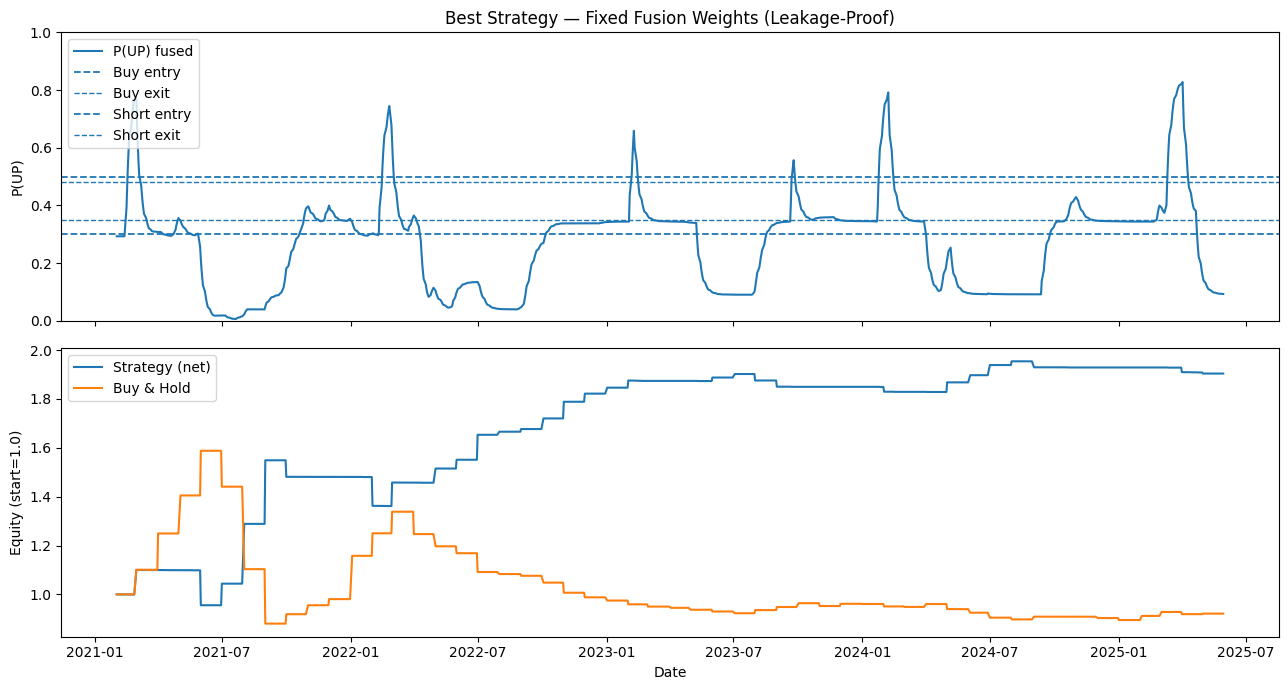

In [81]:
# === Best Config Runner (from your sweep) ===
# Weights: house=0.15, curve=0.00, mills=0.10, season=0.75
# Strategy: buy_entry=0.50, buy_gap=0.02, short_entry=0.30, short_gap=0.05, min_hold=5
#           conf_sizing=False, target_vol=None, sma_len=None

import numpy as np, pandas as pd, matplotlib.pyplot as plt

# ---------------- Inputs ----------------
TEST_START          = pd.Timestamp('2021-01-01')
SMOOTH_SPAN         = int(globals().get('SMOOTH_SPAN', 10))
COST_BPS_PER_SIDE   = 3.0
cost_rate           = COST_BPS_PER_SIDE / 1e4

W = {'house':0.15, 'curve':0.00, 'mills':0.10, 'season':0.75}

def _pick(name_c, name_s):
    if name_c in globals():
        s = globals()[name_c].copy()
    elif name_s in globals():
        s = globals()[name_s].copy()
    else:
        raise RuntimeError(f"Missing: {name_c} or {name_s}")
    s.index = pd.to_datetime(s.index)
    return s.clip(0,1)

if 'px_series' in globals() and isinstance(px_series, pd.Series):
    price = px_series.copy().rename('price')
elif 'px' in globals() and isinstance(px, pd.Series):
    price = px.copy().rename('price')
else:
    raise RuntimeError("Provide `px_series` or `px` (price Series).")

house  = _pick('p_house_c','p_house_s')
curve  = _pick('p_curve_c','p_curve_s')
mills  = _pick('p_mills_c','p_mills_s')
season = _pick('p_season_c','p_sm')

# Align + restrict window
idx = house.index.intersection(curve.index).intersection(mills.index).intersection(season.index).intersection(price.index)
house,curve,mills,season,price = [x.reindex(idx) for x in [house,curve,mills,season,price]]
mask = (idx >= TEST_START)
house,curve,mills,season,price = [x.loc[mask].dropna() for x in [house,curve,mills,season,price]]
common = house.index.intersection(curve.index).intersection(mills.index).intersection(season.index).intersection(price.index)
house,curve,mills,season,price = [x.reindex(common).dropna() for x in [house,curve,mills,season,price]]

# Fused probability (+ cosmetic smoothing)
p_fused = (W['house']*house + W['curve']*curve + W['mills']*mills + W['season']*season).clip(0,1)
p_fused_s = p_fused.ewm(span=SMOOTH_SPAN, adjust=False).mean().clip(0,1)

# ---------------- Strategy (best config) ----------------
buy_entry, buy_gap   = 0.50, 0.02      # long enter / hysteresis gap
short_entry, short_gap = 0.30, 0.05    # short enter / hysteresis gap
min_hold = 5                           # bars; leakage-proof T+1 execution
conf_sizing = False                    # off
target_ann_vol = None                  # no vol targeting
sma_len = None                         # no SMA filter

def trade_engine(p: pd.Series, px: pd.Series):
    p = p.copy(); px = px.reindex(p.index).dropna(); p = p.reindex(px.index)

    buy_exit   = max(0.0, buy_entry - buy_gap)
    short_exit = min(1.0, short_entry + short_gap)

    enter_long  = (p >= buy_entry)
    exit_long   = (p <= buy_exit)
    enter_short = (p <= short_entry)
    exit_short  = (p >= short_exit)

    pos = pd.Series(0.0, index=p.index)
    last_change_i = -10**9
    for i in range(1, len(p)):
        pos.iloc[i] = pos.iloc[i-1]
        if (i - last_change_i) < min_hold:
            continue
        if pos.iloc[i-1] <= 0 and enter_long.iloc[i-1]:
            pos.iloc[i] = 1.0;  last_change_i = i
        elif pos.iloc[i-1] >= 0 and enter_short.iloc[i-1]:
            pos.iloc[i] = -1.0; last_change_i = i
        else:
            if pos.iloc[i-1] > 0 and exit_long.iloc[i-1]:
                pos.iloc[i] = 0.0; last_change_i = i
            if pos.iloc[i-1] < 0 and exit_short.iloc[i-1]:
                pos.iloc[i] = 0.0; last_change_i = i

    # Returns (leakage-proof T+1), with costs
    ret = px.pct_change().fillna(0.0)
    str_ret = (pos * ret).astype(float)
    chg = pos.diff().abs().fillna(0.0)
    net = str_ret - chg * cost_rate
    eq = (1.0 + net).cumprod()
    return pos, net, eq

def metrics(returns, equity):
    ann = 252
    mu = returns.mean()*ann
    sd = returns.std(ddof=0)*np.sqrt(ann)
    shp = (mu/sd) if sd>0 else np.nan
    mdd = (equity/equity.cummax() - 1.0).min()
    cagr = equity.iloc[-1]**(252/len(returns)) - 1.0
    return mu, shp, mdd, cagr

pos, r_best, eq_best = trade_engine(p_fused_s, price)
eq_bh = (1.0 + price.pct_change().fillna(0.0)).cumprod()

ann, shp, mdd, cagr = metrics(r_best, eq_best)
ann_bh, shp_bh, mdd_bh, cagr_bh = metrics(price.pct_change().fillna(0.0), eq_bh)

print("=== Best Config (from sweep) — Results (2021→current) ===")
print(f"Weights: {W}")
print(f"Params: buy_entry={buy_entry}, buy_gap={buy_gap}, short_entry={short_entry}, short_gap={short_gap}, "
      f"min_hold={min_hold}, conf_sizing={conf_sizing}, target_vol={target_ann_vol}, sma_len={sma_len}")
print(f"Strategy  Ann.Return: {ann: .4f}  Sharpe: {shp: .3f}  MaxDD: {mdd: .3f}  CAGR: {cagr: .4f}")
print(f"Buy&Hold  Ann.Return: {ann_bh: .4f}  Sharpe: {shp_bh: .3f}  MaxDD: {mdd_bh: .3f}  CAGR: {cagr_bh: .4f}")

# ---------------- Plots ----------------
fig, axes = plt.subplots(2,1,figsize=(13,7), sharex=True)

axes[0].plot(p_fused_s.index, p_fused_s.values, label='P(UP) fused')
axes[0].axhline(buy_entry,   linestyle='--', linewidth=1.3, label='Buy entry')
axes[0].axhline(buy_entry-buy_gap, linestyle='--', linewidth=1.0, label='Buy exit')
axes[0].axhline(short_entry, linestyle='--', linewidth=1.3, label='Short entry')
axes[0].axhline(short_entry+short_gap, linestyle='--', linewidth=1.0, label='Short exit')
axes[0].set_ylim(0,1); axes[0].set_ylabel('P(UP)'); axes[0].legend(loc='upper left')
axes[0].set_title("Best Strategy — Fixed Fusion Weights (Leakage-Proof)")

axes[1].plot(eq_best.index, eq_best.values, label='Strategy (net)')
axes[1].plot(eq_bh.index,   eq_bh.values,   label='Buy & Hold')
axes[1].set_ylabel('Equity (start=1.0)'); axes[1].set_xlabel('Date')
axes[1].legend(loc='upper left')

plt.tight_layout(); plt.show()
